In [1]:
!rm -rf img/ && mkdir -p img

In [2]:
import time

import figtools as ftl
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim

In [3]:
from helper.data import DataLoader, init_state
from helper.ukf import init_ukf

In [4]:
torch.manual_seed(0)
assert torch.all(torch.randint(10, (10,)) == torch.tensor([4, 9, 3, 0, 3, 9, 7, 3, 7, 3]))

In [5]:
data_loader = DataLoader(phi=torch.tensor([0., np.pi / 2., np.pi, 3. / 2. * np.pi]),
                         v0=torch.tensor([1., 2., 3., 4.]),
                         n=30,
                         n_repeat=7)
X, _ = data_loader(window_size=100, randomize=True)
X.shape

torch.Size([4, 2, 111, 100])

In [6]:
def train_window(X, *, state_cov, process_noise, measurement_noise, learning_rate):
    b, _, _ = X.shape
    
    ukf = init_ukf(batch_size=b,
                   process_noise=process_noise,
                   measurement_noise=measurement_noise)
    
    optimizer = torch.optim.SGD(ukf.parameters(), lr=learning_rate)
    optimizer.zero_grad()

    Y, state, state_covs = ukf(X, init_state(X), state_cov)
    loss = torch.sum((X - Y)**2, dim=(1, 2))
    loss.backward(torch.ones(b))

    optimizer.step()

    return {
        'process_noise': ukf.cell.process_noise.detach(),
        'measurement_noise': ukf.cell.measurement_noise.detach(),
        'state_cov': state_covs[:, :, :, -1].detach(),
        'loss': loss.tolist(),
    }


def train_epoch(X, *, learning_rate, w_max=None):
    b, _, w, _ = X.shape
    if w_max:
        w = min(w, w_max)
    
    losses = []
    state_cov = torch.eye(4).repeat(b, 1, 1)
    
    rnd = torch.rand(b, 2)
    process_noise = torch.zeros(b, 10)
    process_noise[:, 0] = rnd[:, 0]
    process_noise[:, 2] = rnd[:, 0]
    process_noise[:, 5] = rnd[:, 1]
    process_noise[:, 9] = rnd[:, 1]
    
    rnd = torch.rand(b, 1)
    measurement_noise = torch.zeros(b, 3)
    measurement_noise[:, 0] = rnd[:, 0]
    measurement_noise[:, 2] = rnd[:, 0]
    
    stats = None
    for i in range(w):
        stats = train_window(X[:, :, i],
                             state_cov=state_cov,
                             process_noise=process_noise,
                             measurement_noise=measurement_noise,
                             learning_rate=learning_rate)
        
        process_noise = stats['process_noise']
        measurement_noise = stats['measurement_noise']
        state_cov = stats['state_cov']
        losses.append(stats['loss'])
    
    return losses, stats


def train(n_epochs, w_max=None, verbose=False):
    for i in range(n_epochs):
        t_start = time.time()
        loss, stats = train_epoch(X, learning_rate=1e-4, w_max=w_max)
        t_end = time.time()

        if verbose:
            print(f'Epoch #{i+1}:', f'(elapsed time: {(t_end-t_start):.2f}s)')    
            print(np.array(loss))
    
    return stats

In [7]:
stats = train(1, verbose=True)
state_cov = stats['state_cov']
process_noise = stats['process_noise']
measurement_noise = stats['measurement_noise']

Epoch #1: (elapsed time: 19.85s)
[[  44.88830185  122.25004578  748.24902344 1572.88208008]
 [  45.06971741  122.19615173  405.93481445  796.96173096]
 [  44.8835907   122.14352417  362.42764282  716.41131592]
 [  43.22971725  121.88359833  328.70422363  646.07940674]
 [  44.54006958  122.04888153  318.31008911  630.93566895]
 [  44.03580475  122.00104523  304.56173706  601.37359619]
 [  44.19948959  121.95598602  294.82958984  580.30169678]
 [  44.03195572  121.91197968  287.80975342  562.67370605]
 [  39.48061752  109.68250275  254.54582214  493.74429321]
 [  43.66147995  121.83255768  279.63464355  538.35119629]
 [  42.20753098  121.61347198  276.3664856   524.07757568]
 [  39.08259201  109.58230591  247.89027405  469.87438965]
 [  38.95881653  109.55201721  246.8052063   464.7074585 ]
 [  43.14229202  121.69187164  273.33514404  511.5461731 ]
 [  38.70484924  109.4910965   245.33908081  456.39523315]
 [  41.58672714  121.46363068  271.89865112  501.41815186]
 [  42.73788452  121.59

In [8]:
from ukf import UKFCell

print('Process noise:')
print(UKFCell.tril_square(process_noise, 4))

print('')

print('Measurement noise:')
print(UKFCell.tril_square(measurement_noise, 2))

Process noise:
tensor([[[3.7551e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.7551e-01, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 4.6106e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6106e-01]],

        [[3.7247e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.7247e-02, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.7829e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7829e-01]],

        [[1.2596e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.2596e-04, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3831e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3831e-01]],

        [[2.2150e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2150e-02, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 6.5238e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5238e-01]]])

Measurement noise:
tensor([[[3.5

In [9]:
def evaluate(X, *, state_cov, process_noise, measurement_noise):
    b, _, _ = X.shape
    
    with torch.no_grad():
        ukf = init_ukf(batch_size=b,
                       process_noise=process_noise,
                       measurement_noise=measurement_noise)
        y, _, _ = ukf(X, init_state(X), state_cov)
    
    return y

In [10]:
X_pred = evaluate(X[:, :, -1], state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
torch.sum((X[:, :, -1] - X_pred)**2, dim=(1, 2))

tensor([ 35.7740, 120.4583, 270.0098, 480.4994])

In [11]:
X_pred.shape, X.shape

(torch.Size([4, 2, 100]), torch.Size([4, 2, 111, 100]))

[Download pred_b1_train.png],[Download pred_b2_train.png],[Download pred_b3_train.png],[Download pred_b4_train.png]

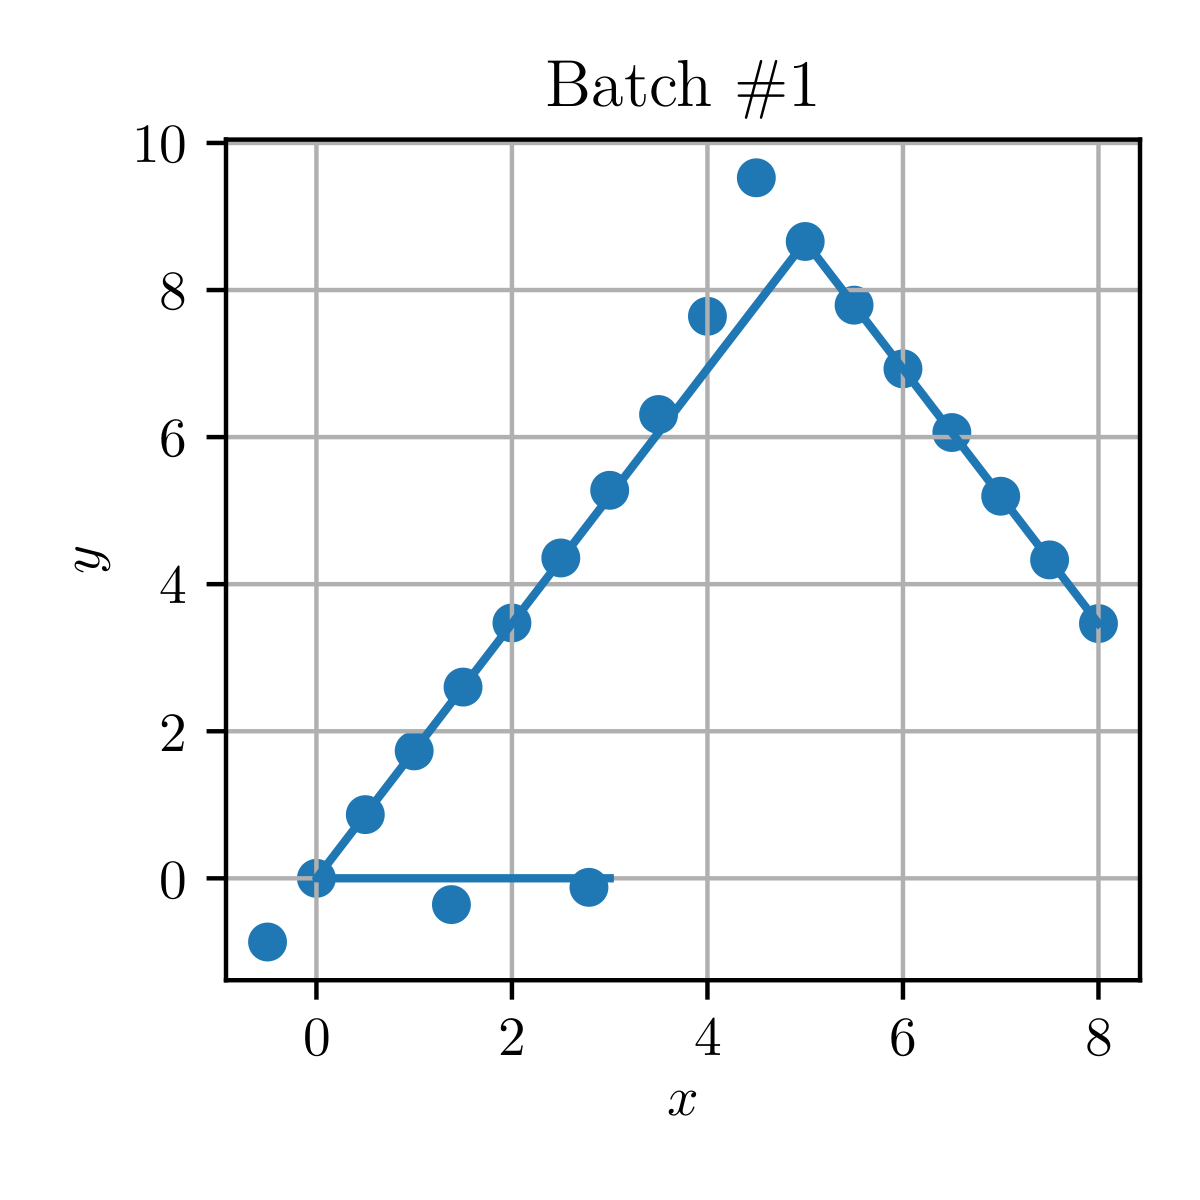
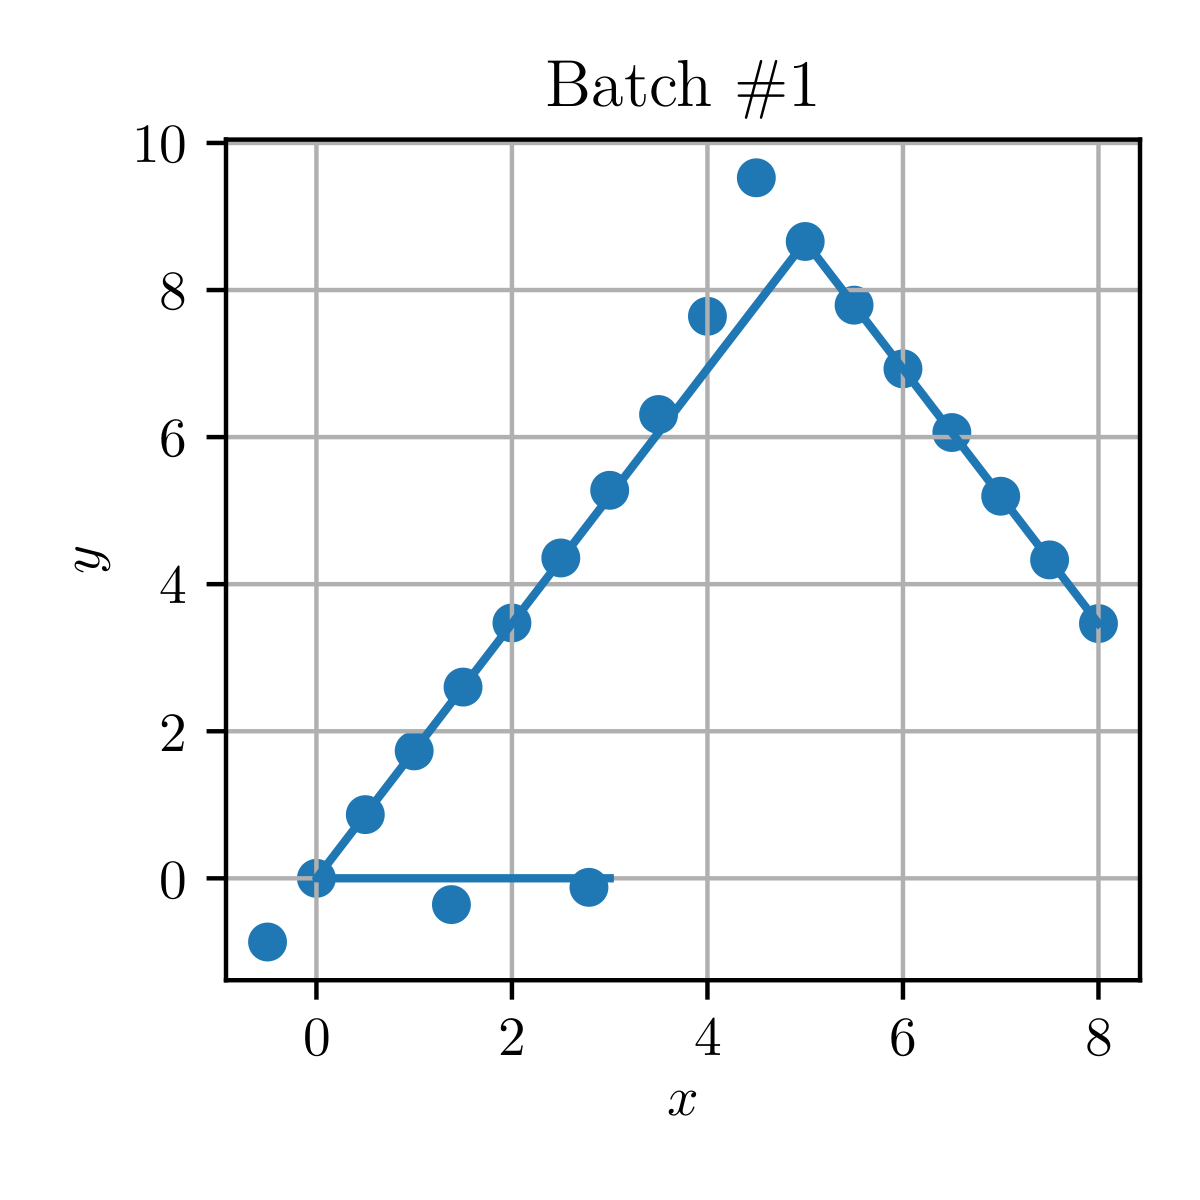
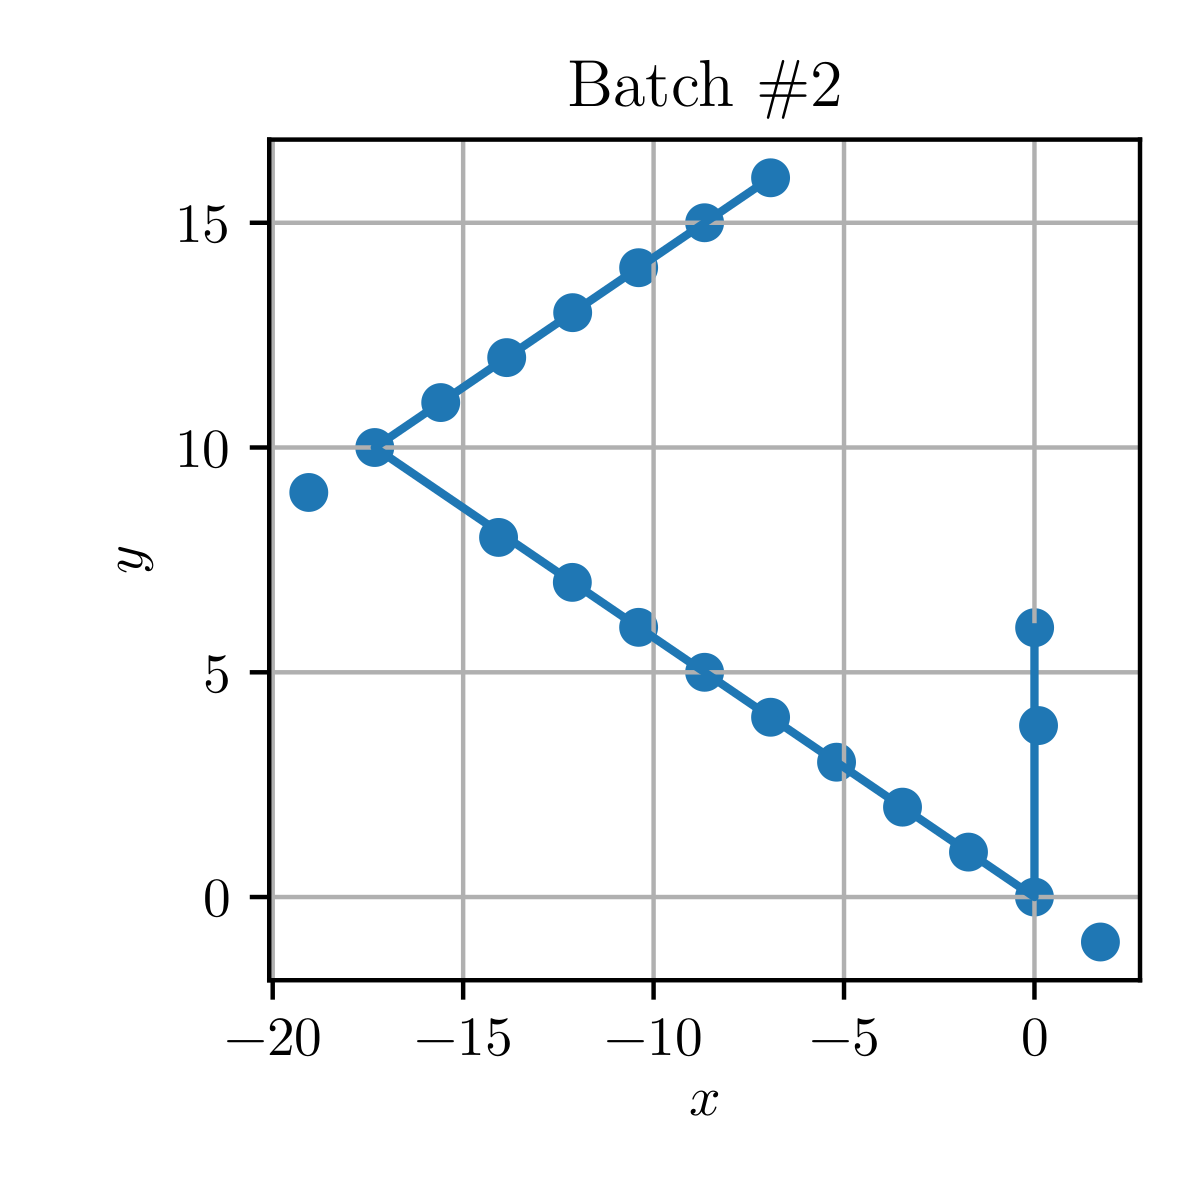
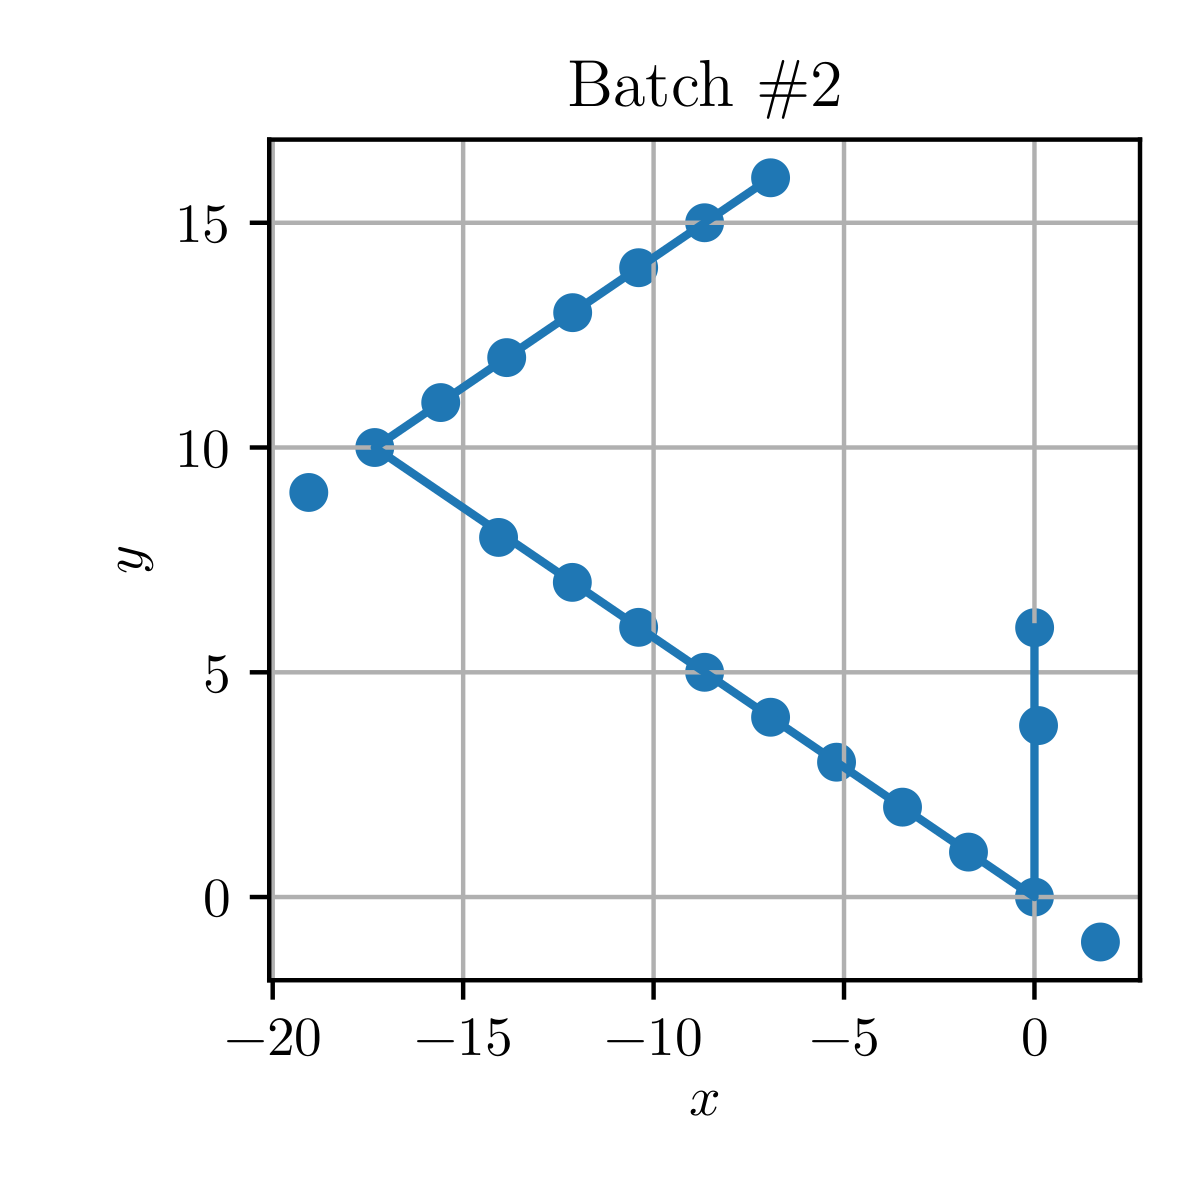
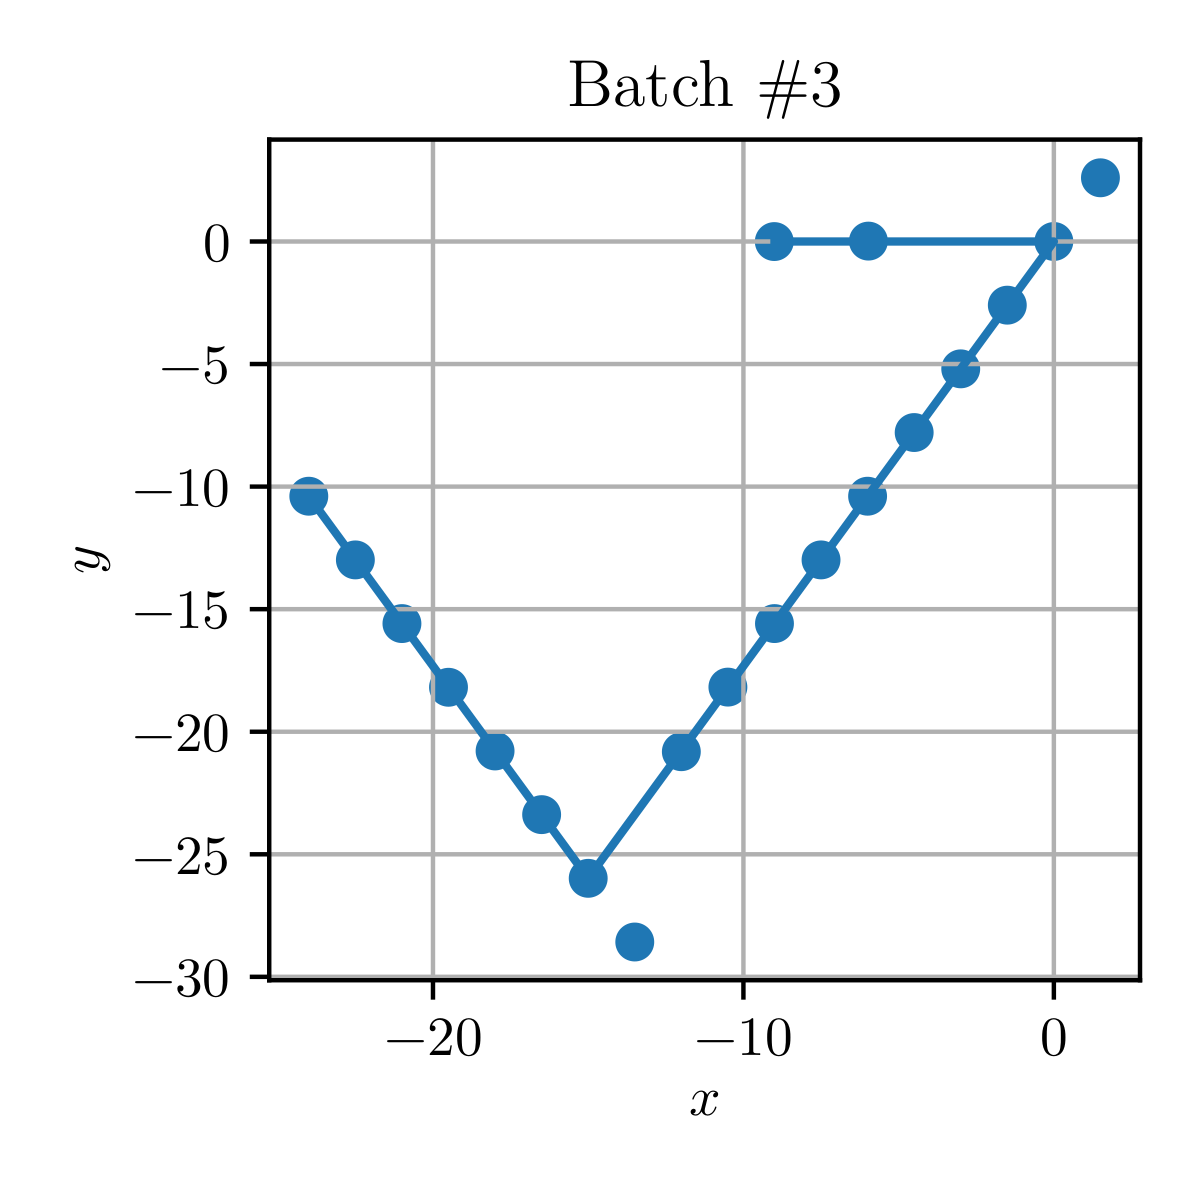
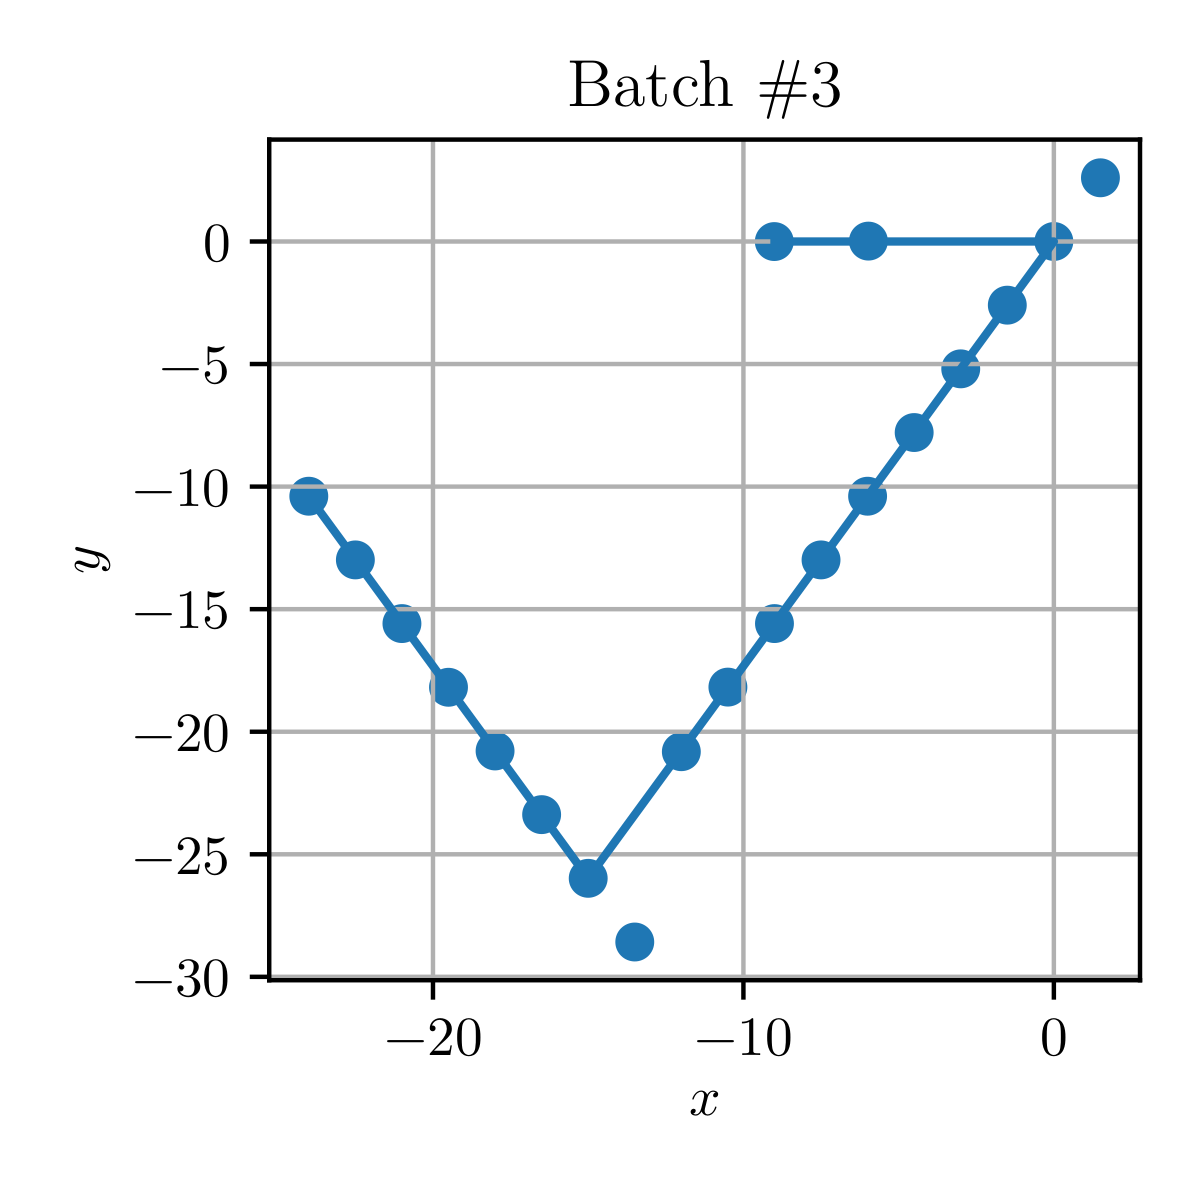
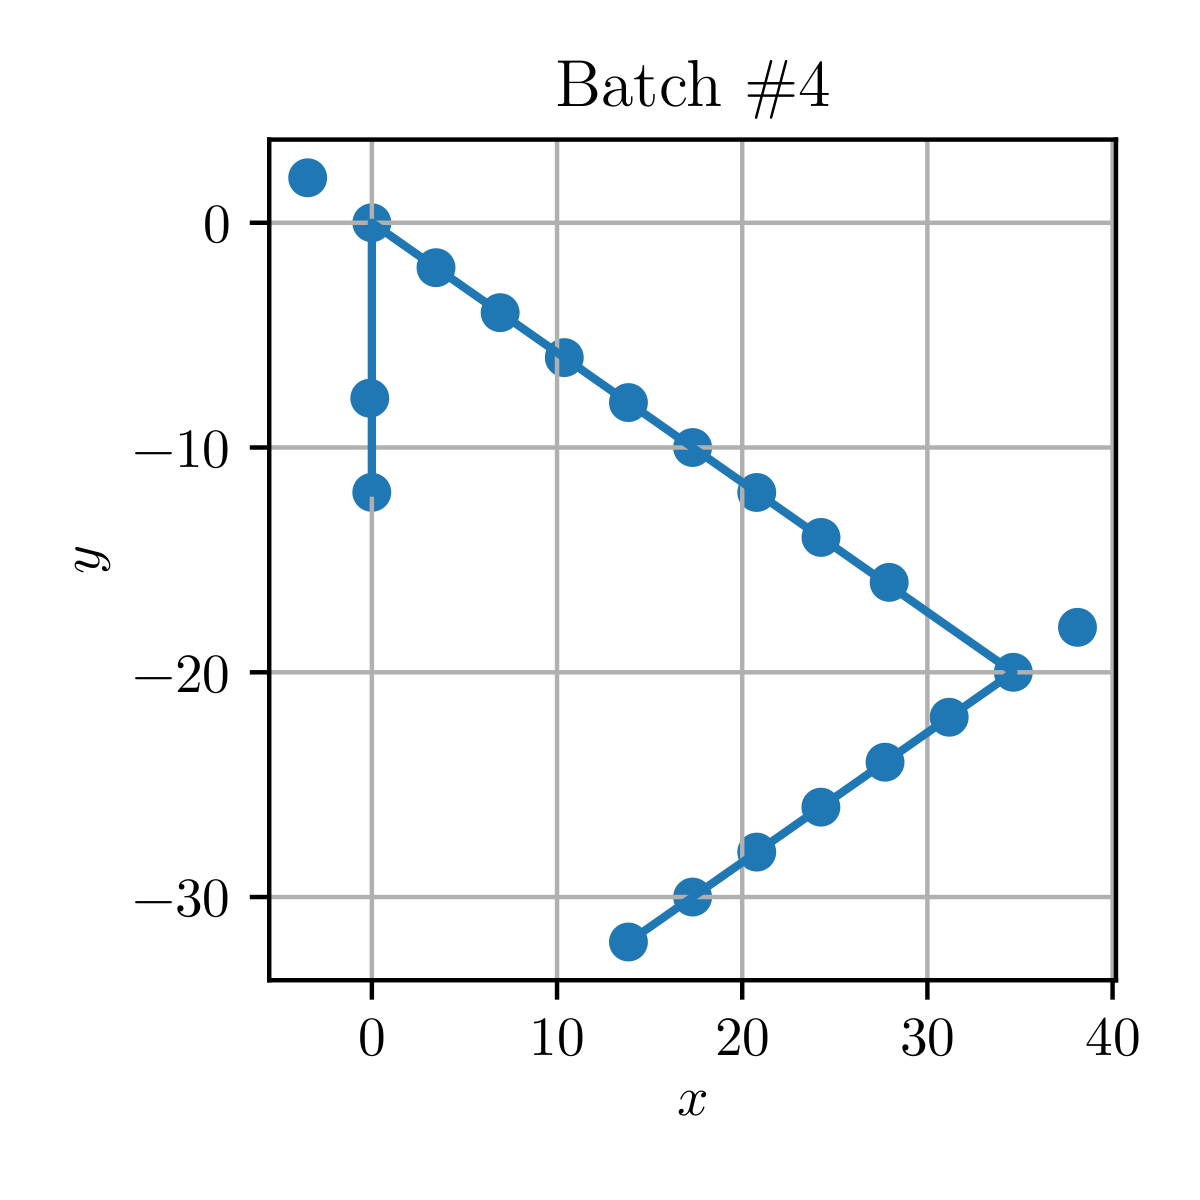
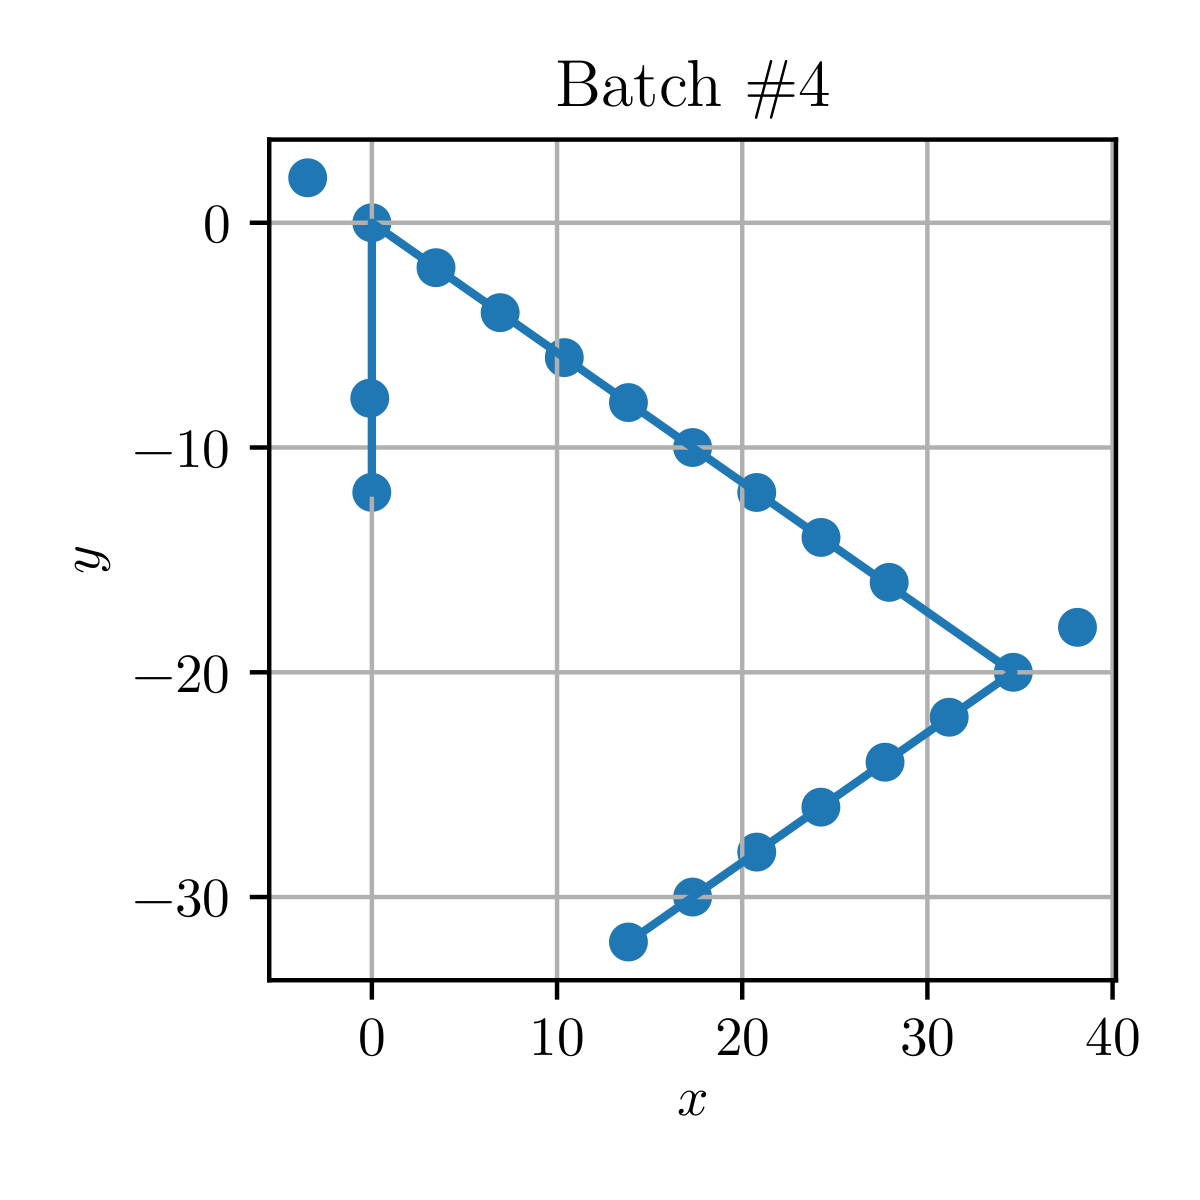

In [12]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 0, 'pred_b1_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 1, 'pred_b2_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 2, 'pred_b3_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 3, 'pred_b4_train'),
], n_columns=4)

[Download loss_b1_train.png],[Download loss_b2_train.png],[Download loss_b3_train.png],[Download loss_b4_train.png]

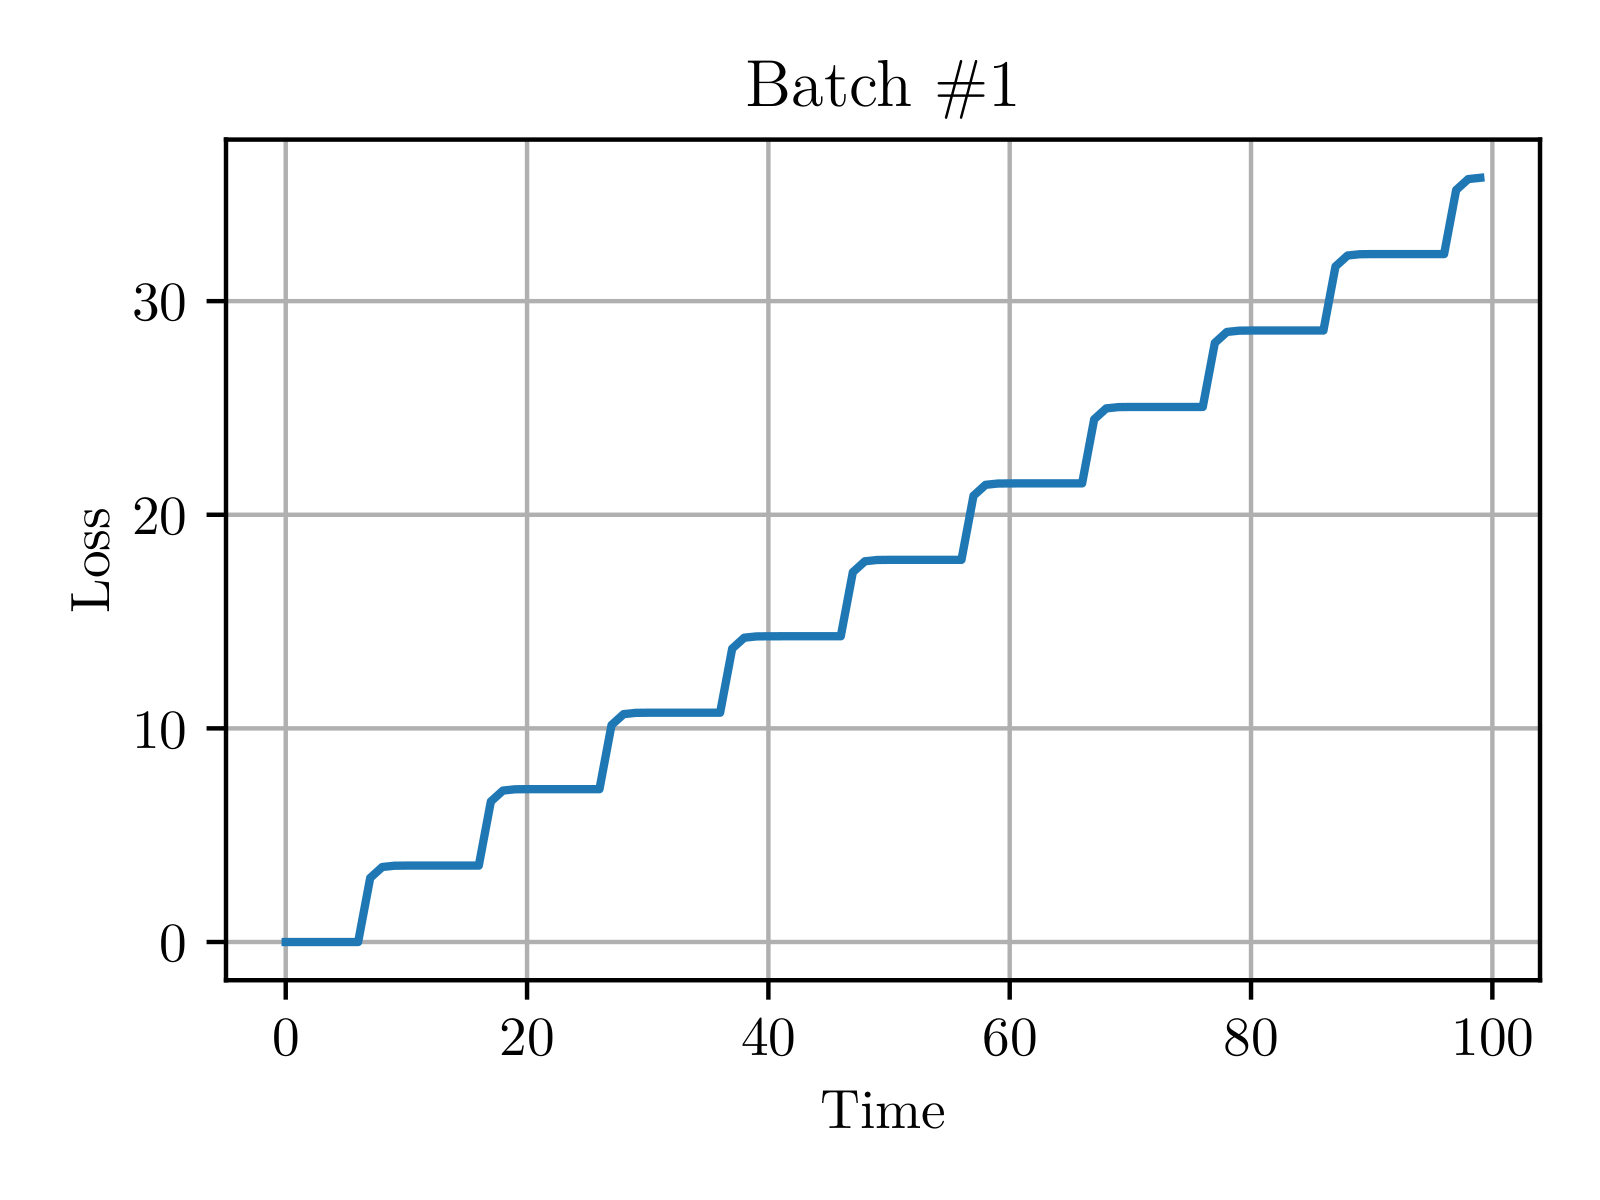
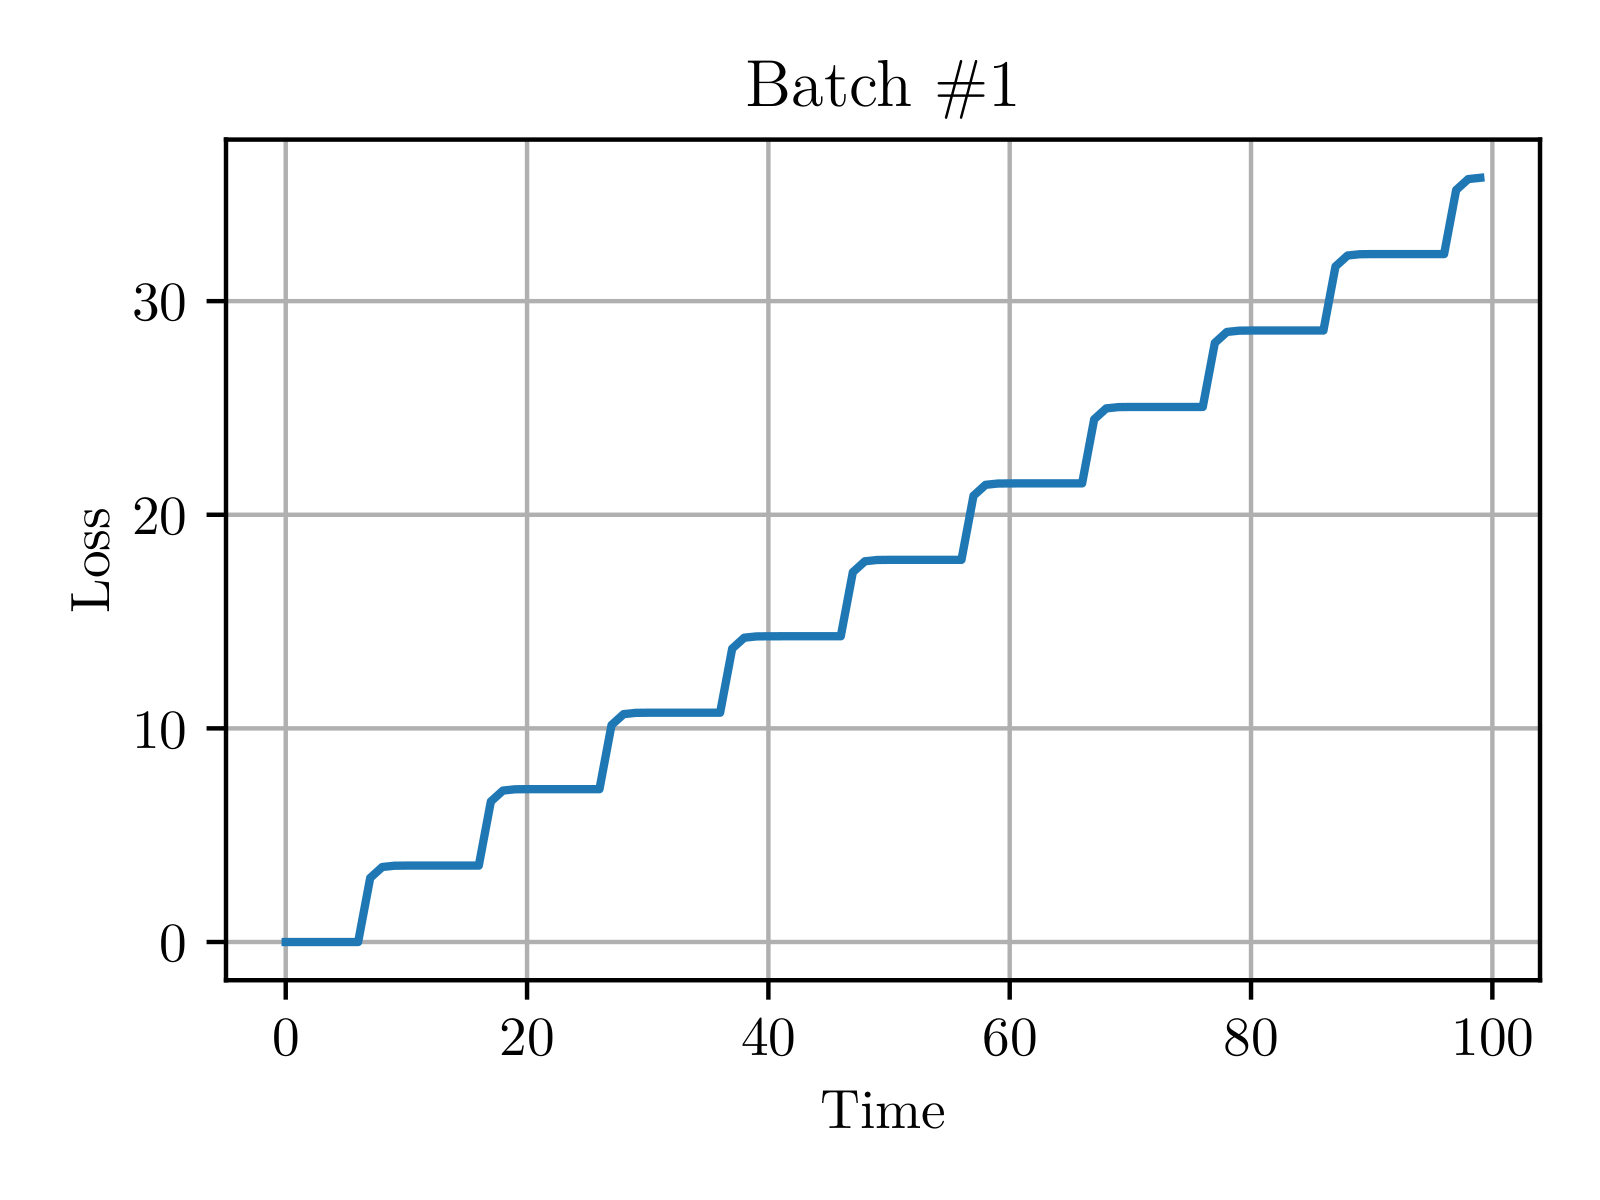
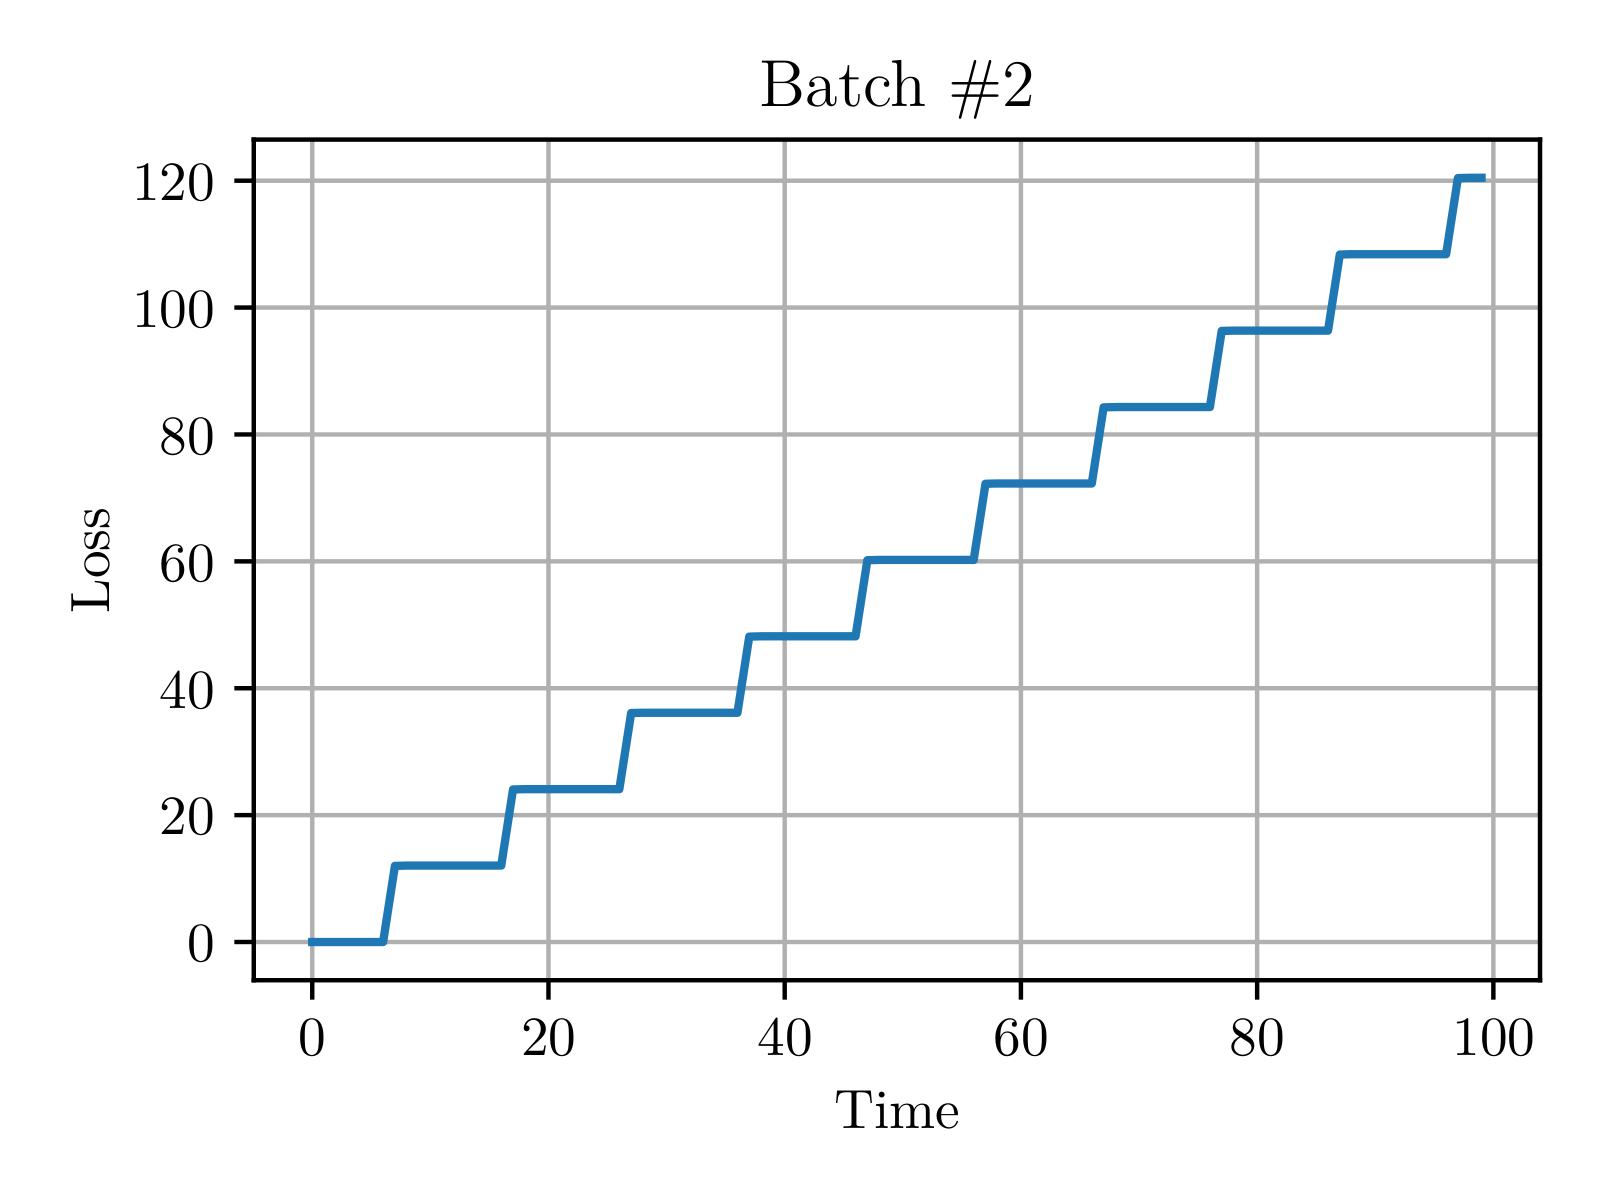
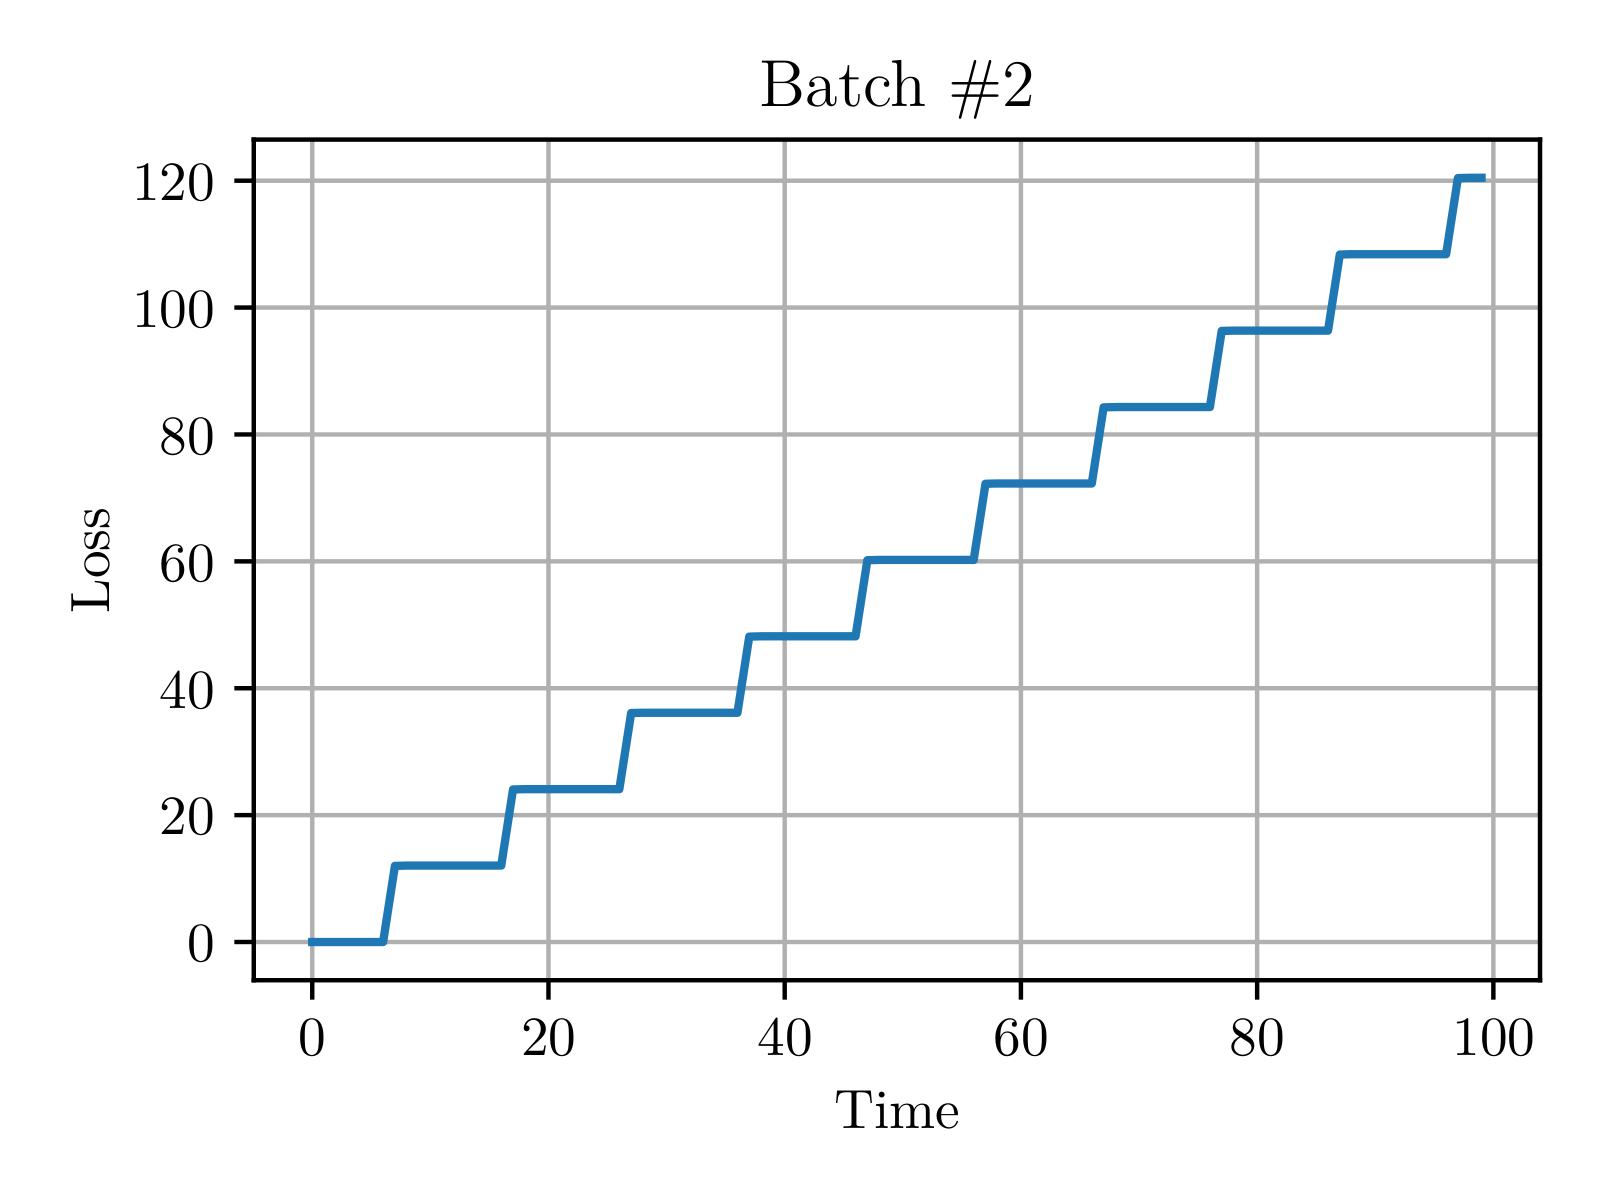
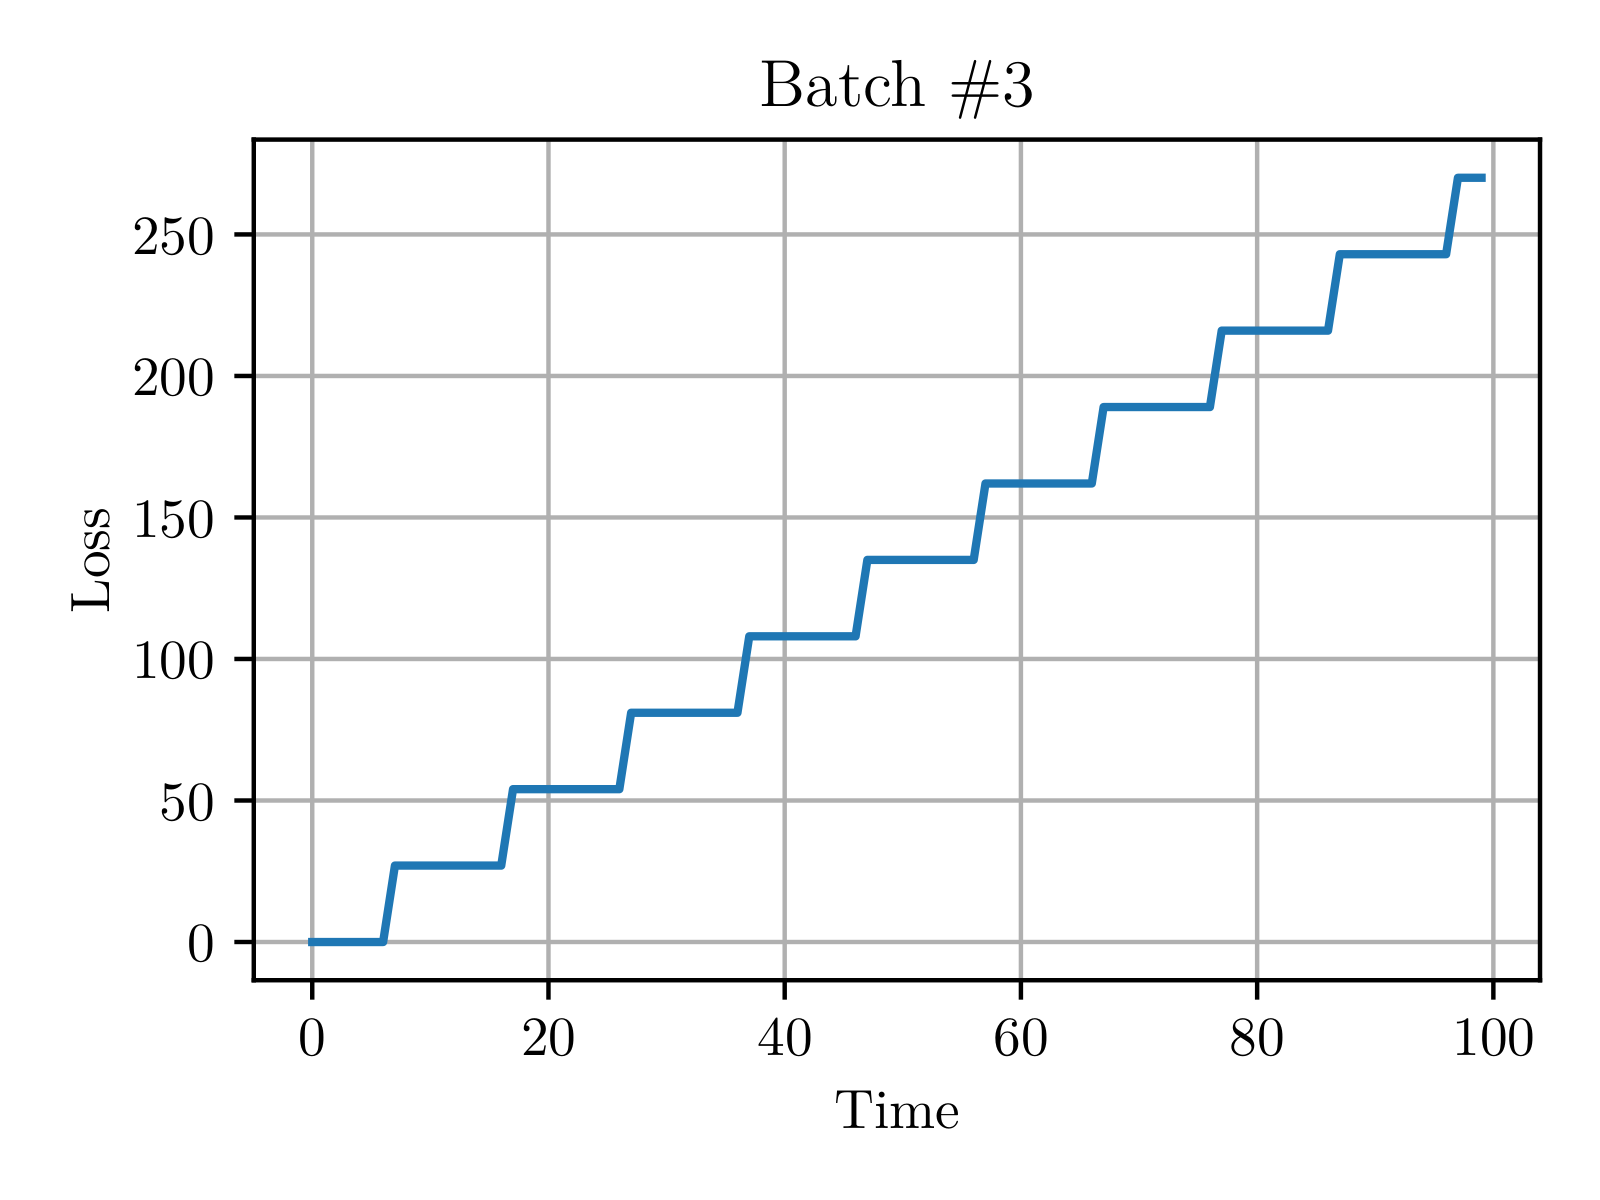
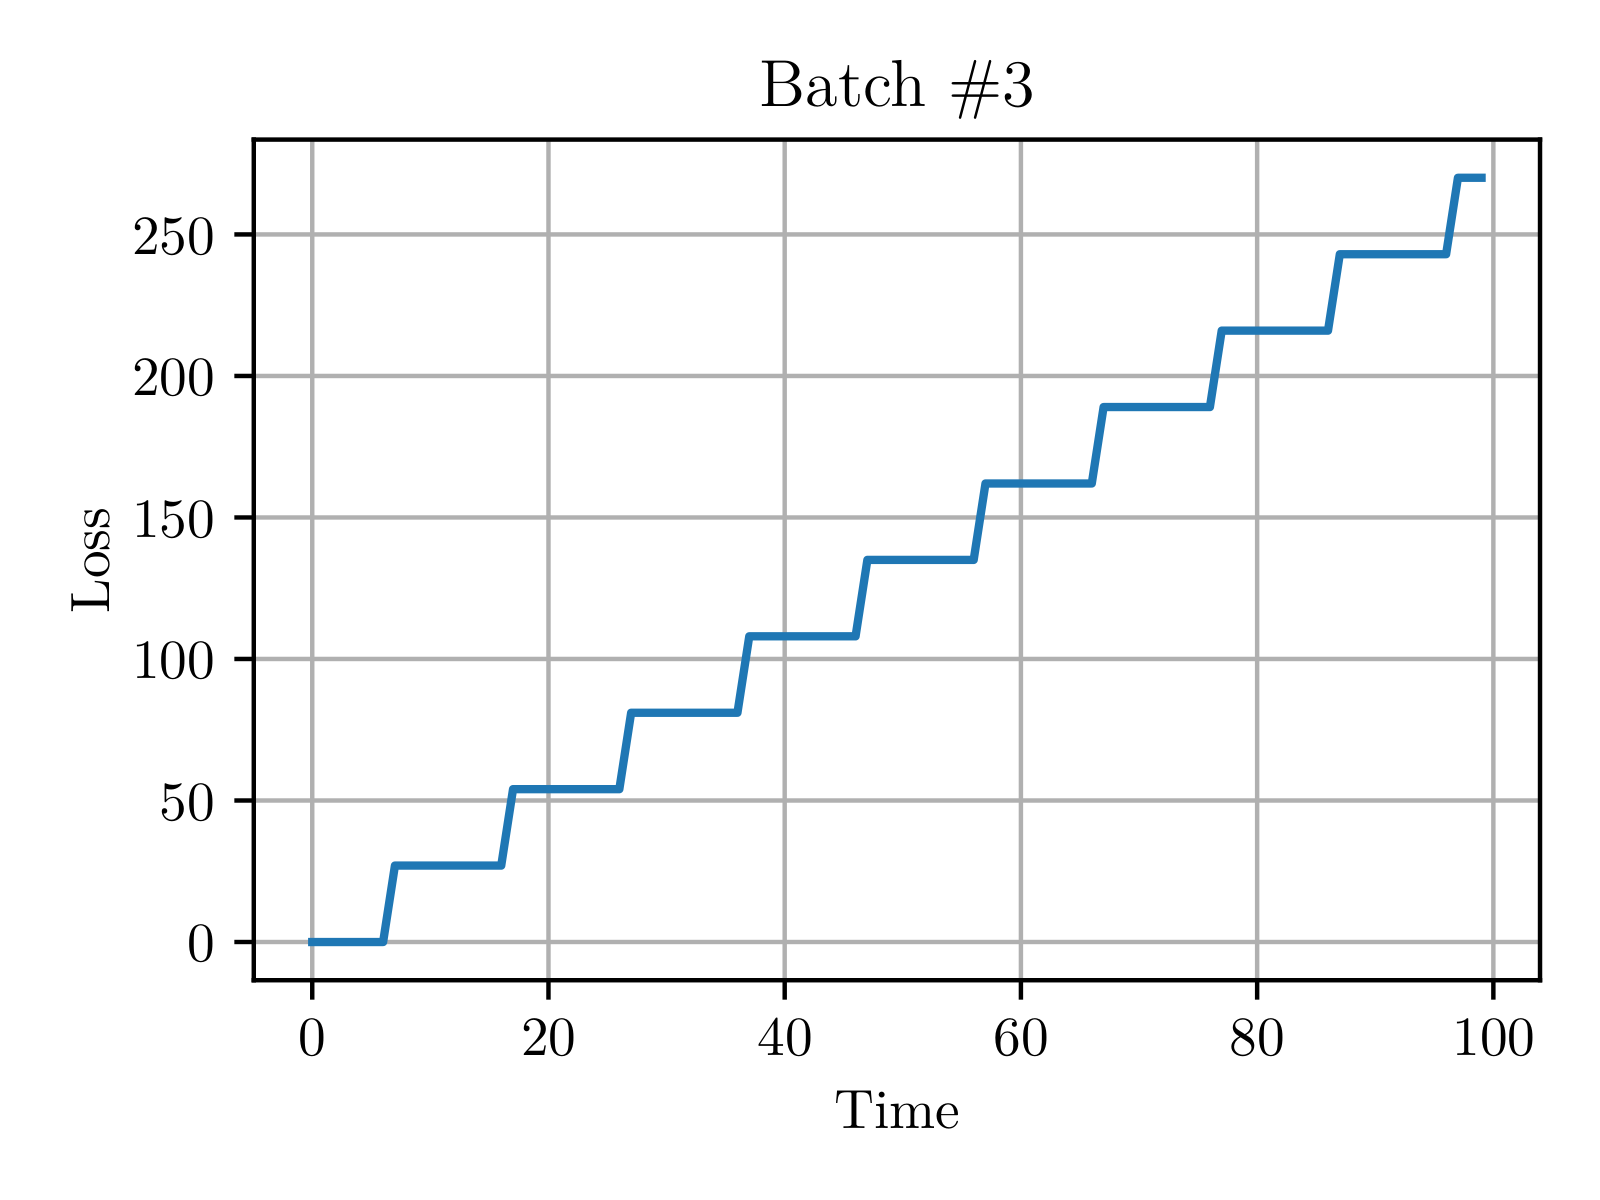
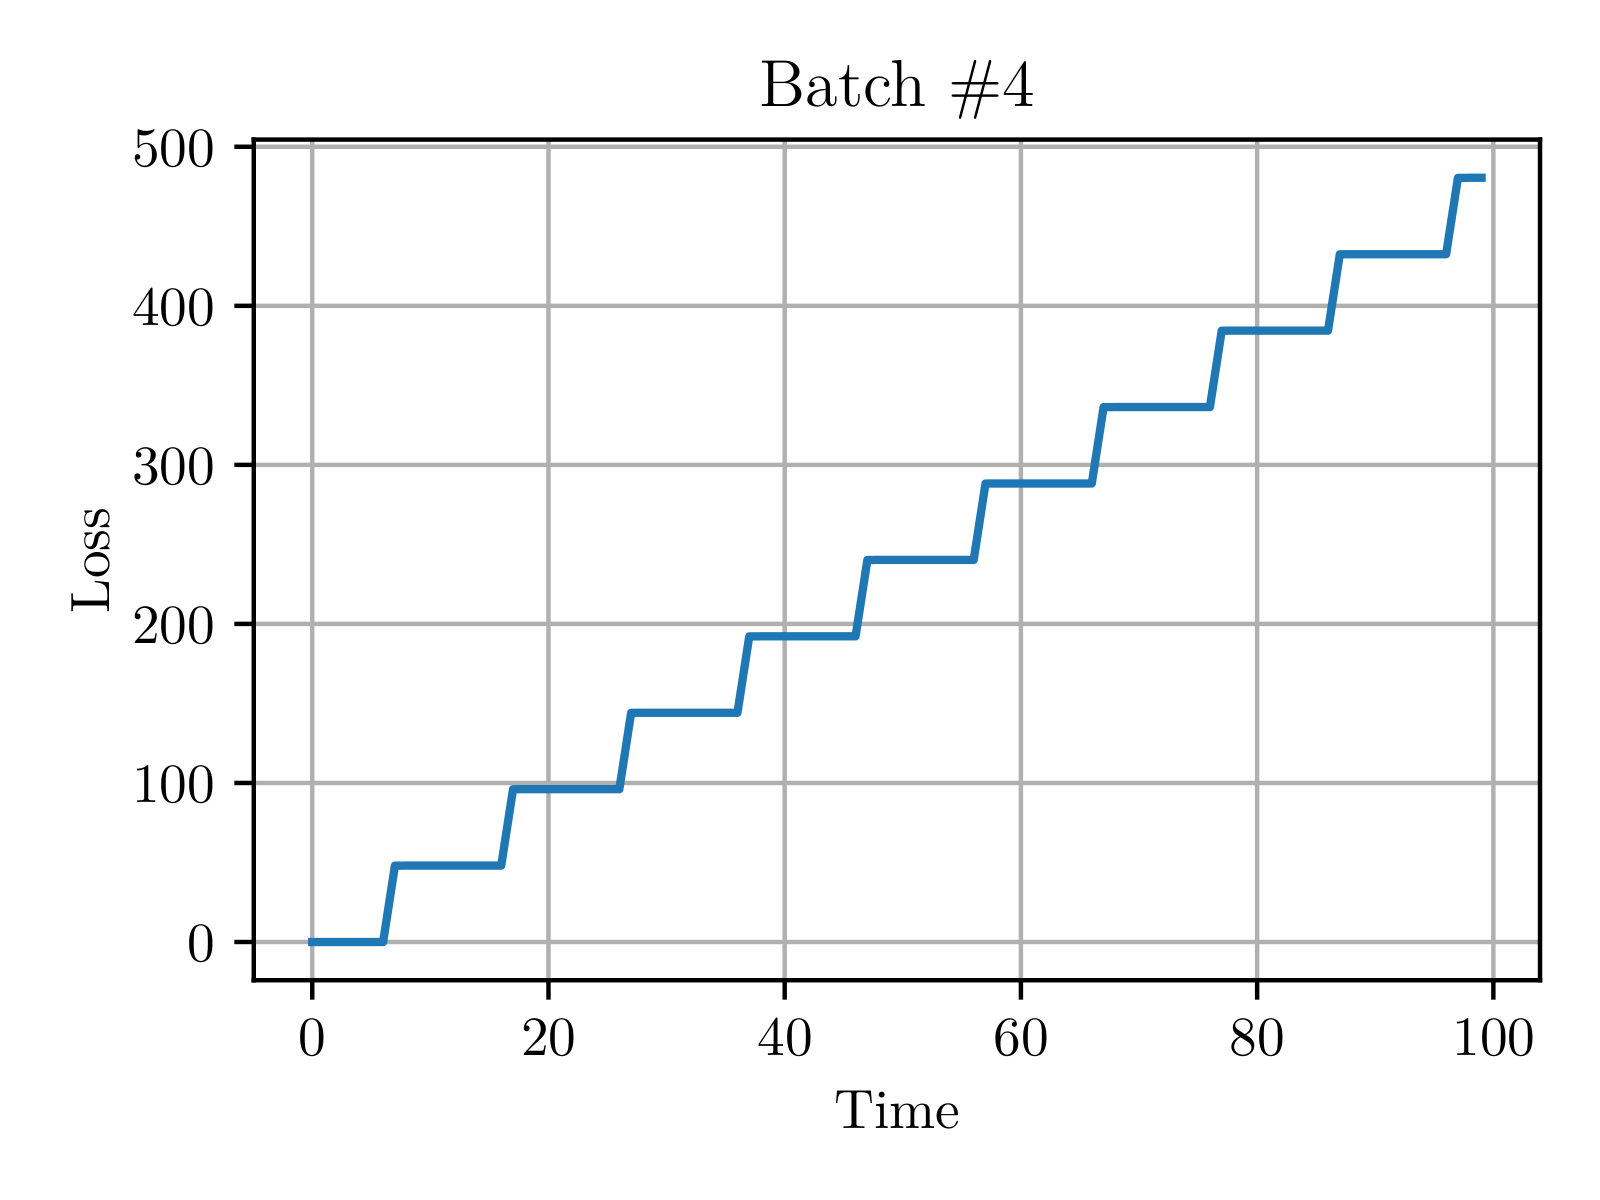
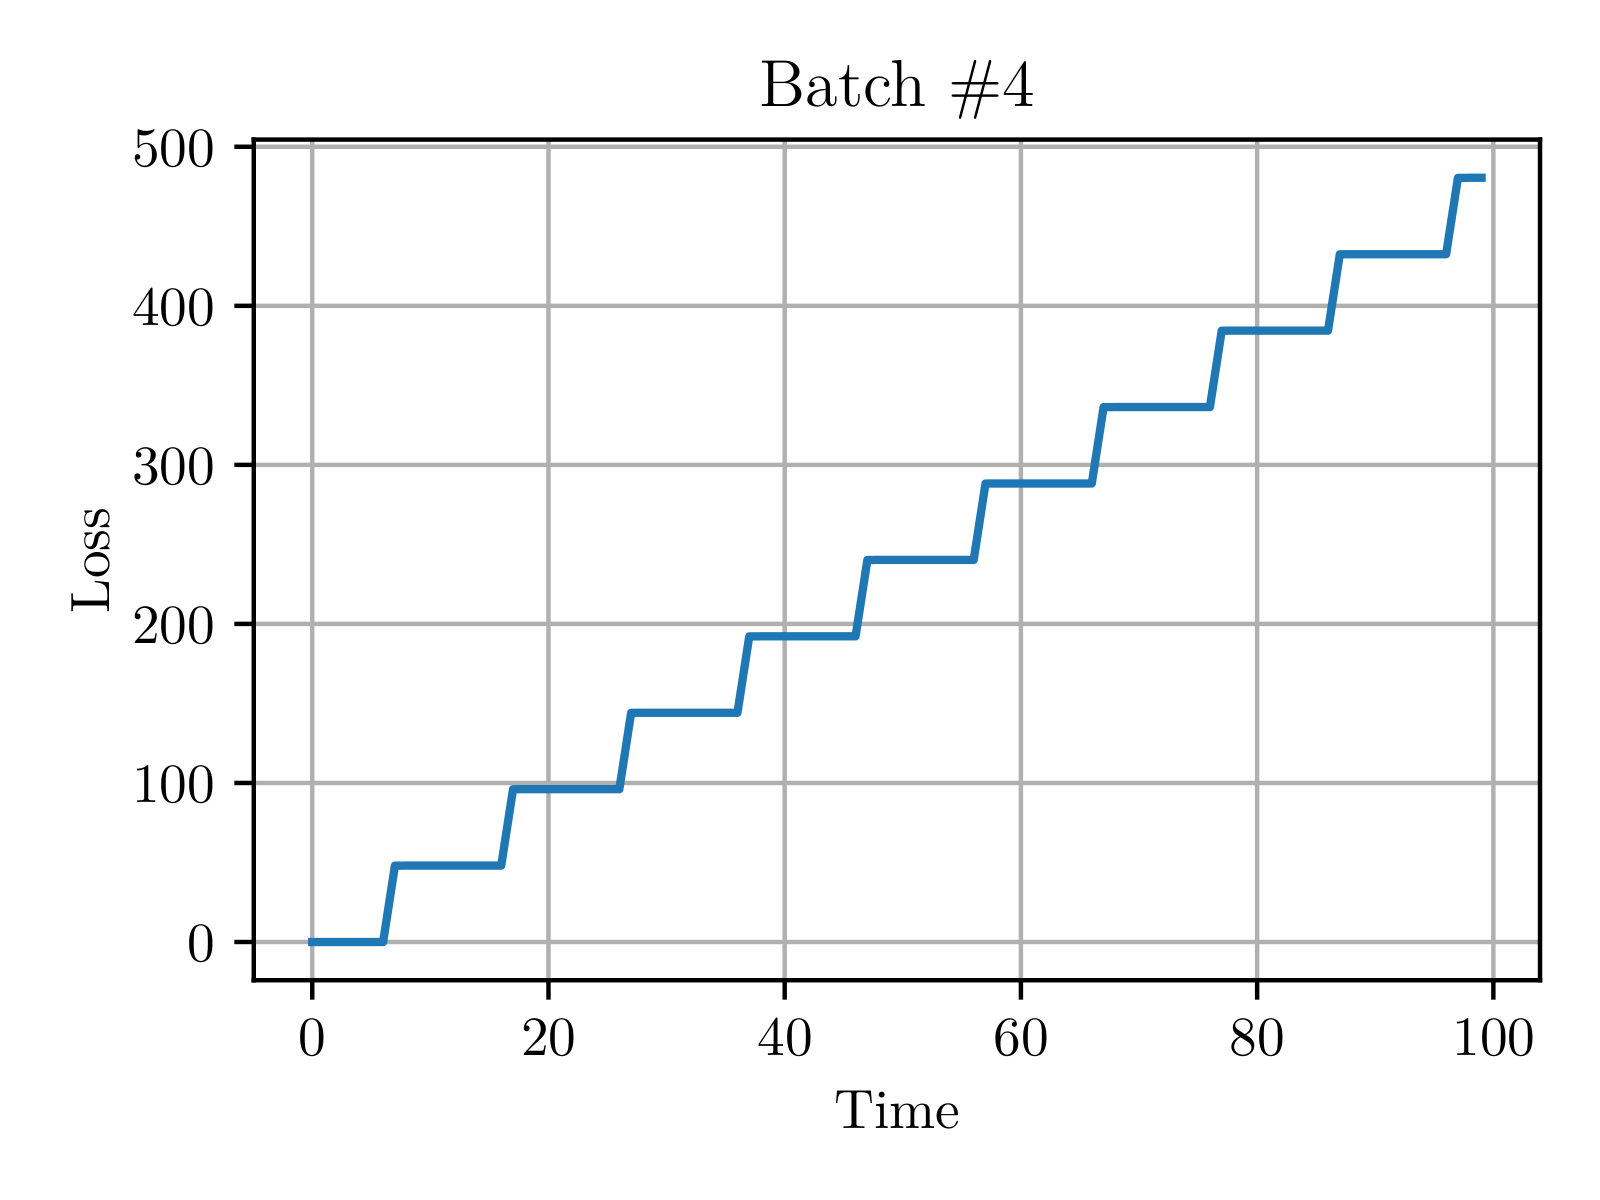

In [13]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X[:, :, -1] - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses, 0, 'loss_b1_train'),
    plot(losses, 1, 'loss_b2_train'),
    plot(losses, 2, 'loss_b3_train'),
    plot(losses, 3, 'loss_b4_train'),
], n_columns=4)

In [14]:
X, _ = data_loader()

In [15]:
X_pred = evaluate(X, state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
X_pred.shape

torch.Size([4, 2, 210])

[Download pred_b1.png],[Download pred_b2.png],[Download pred_b3.png],[Download pred_b4.png]

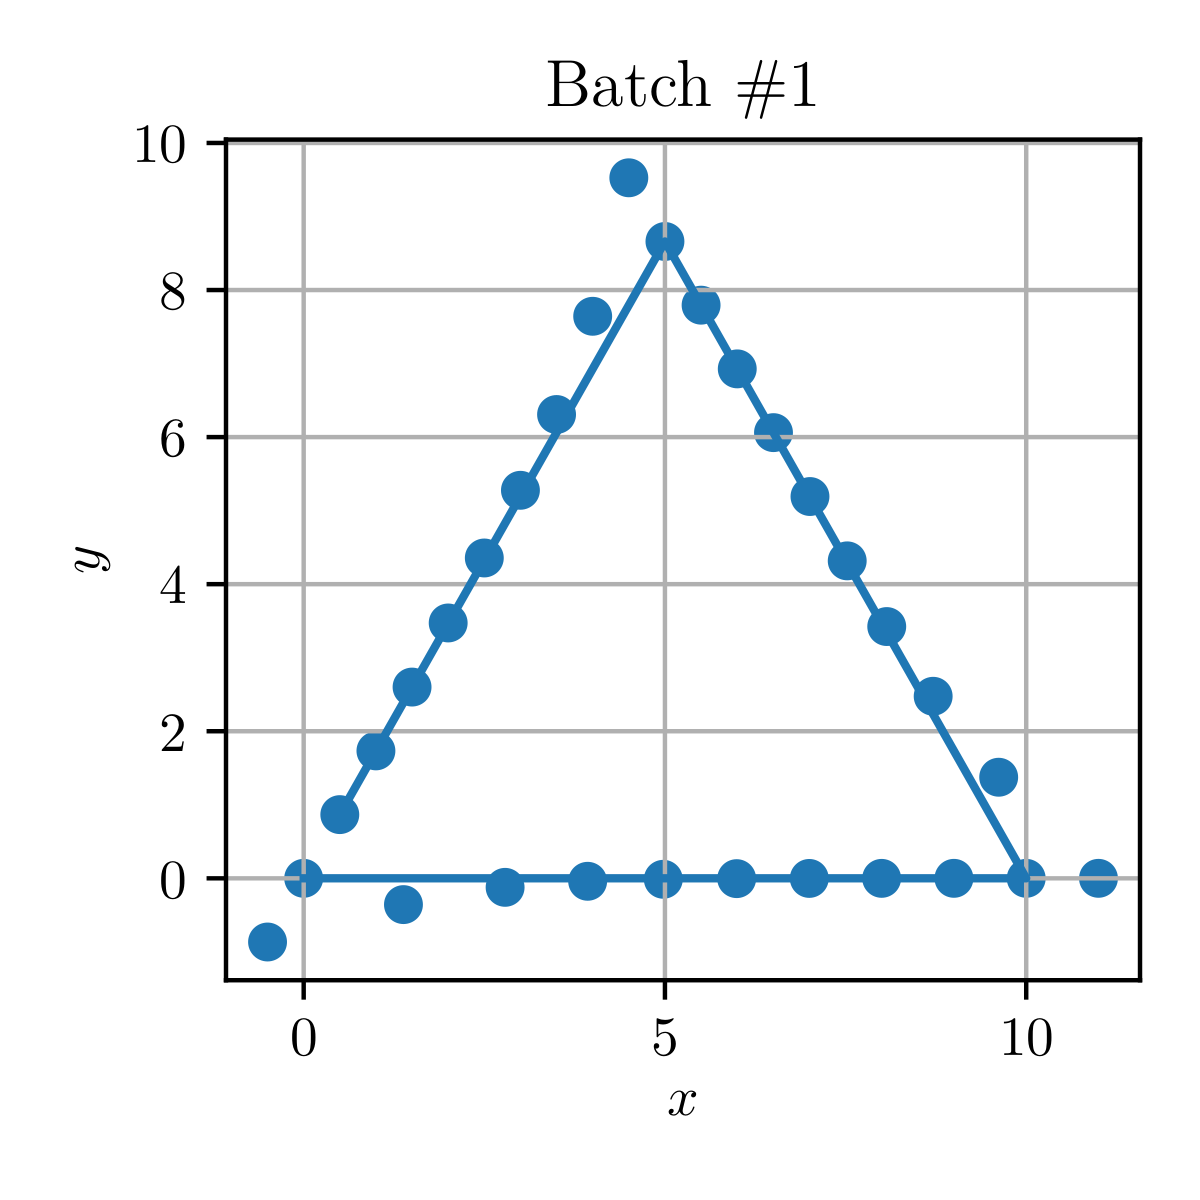
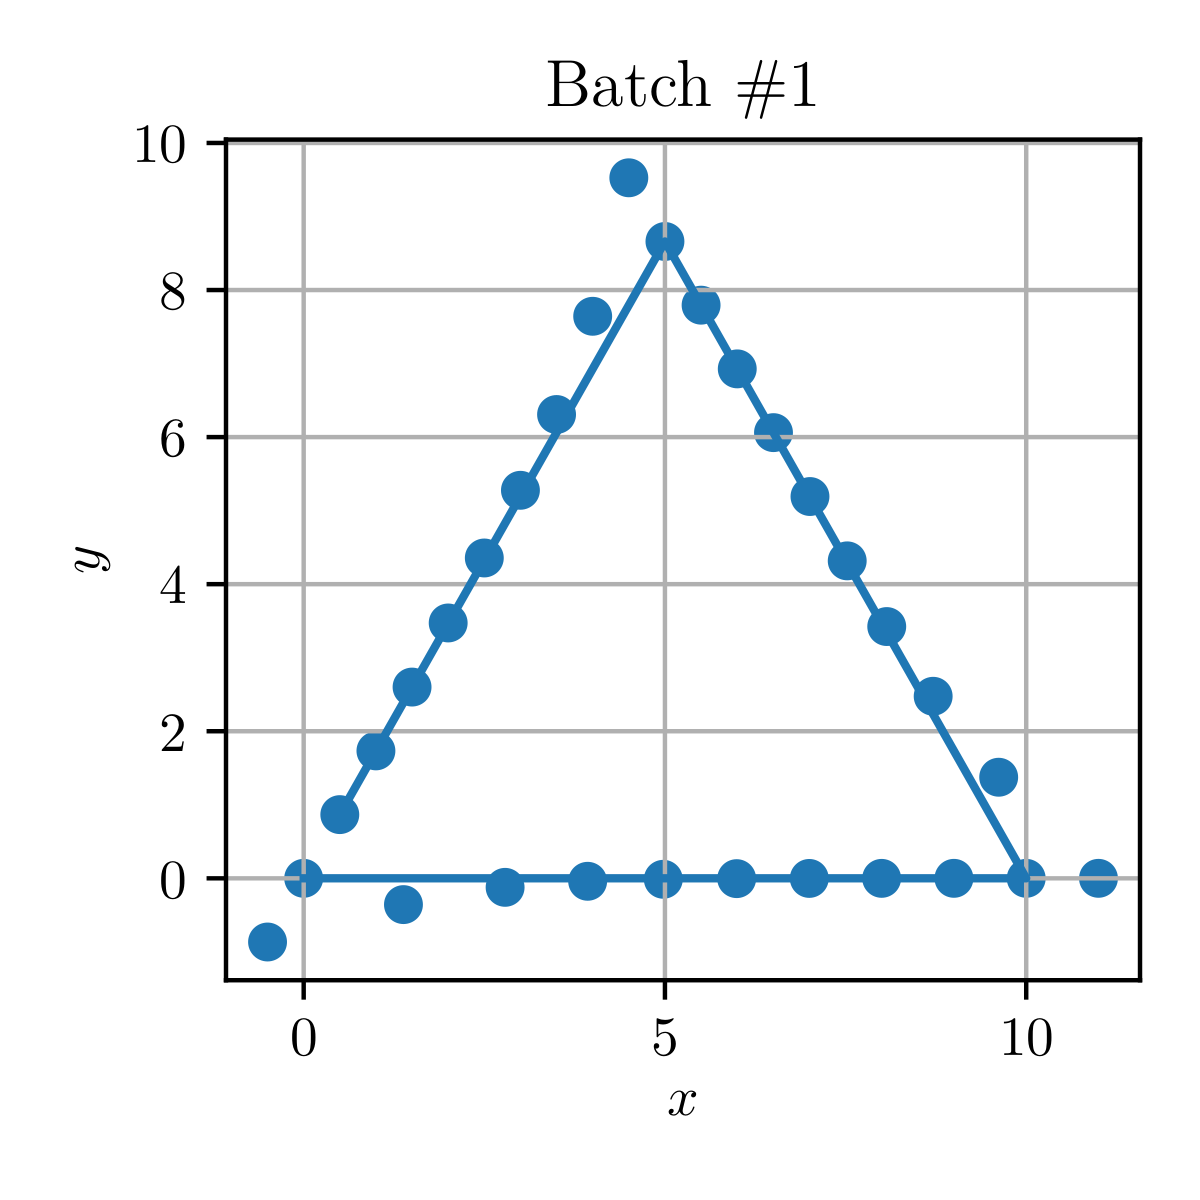
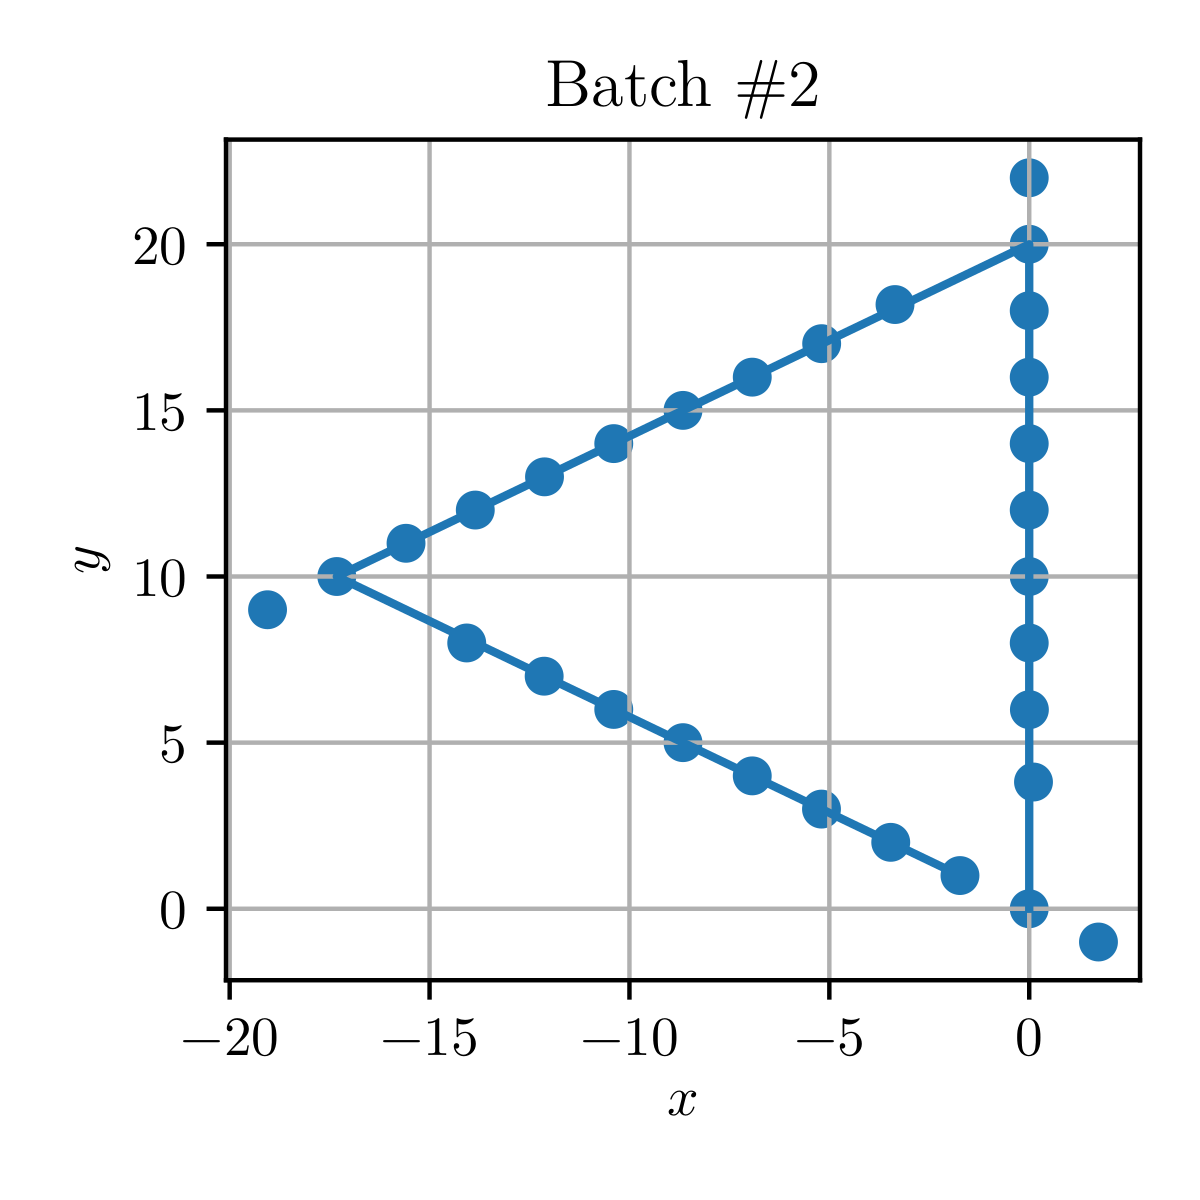
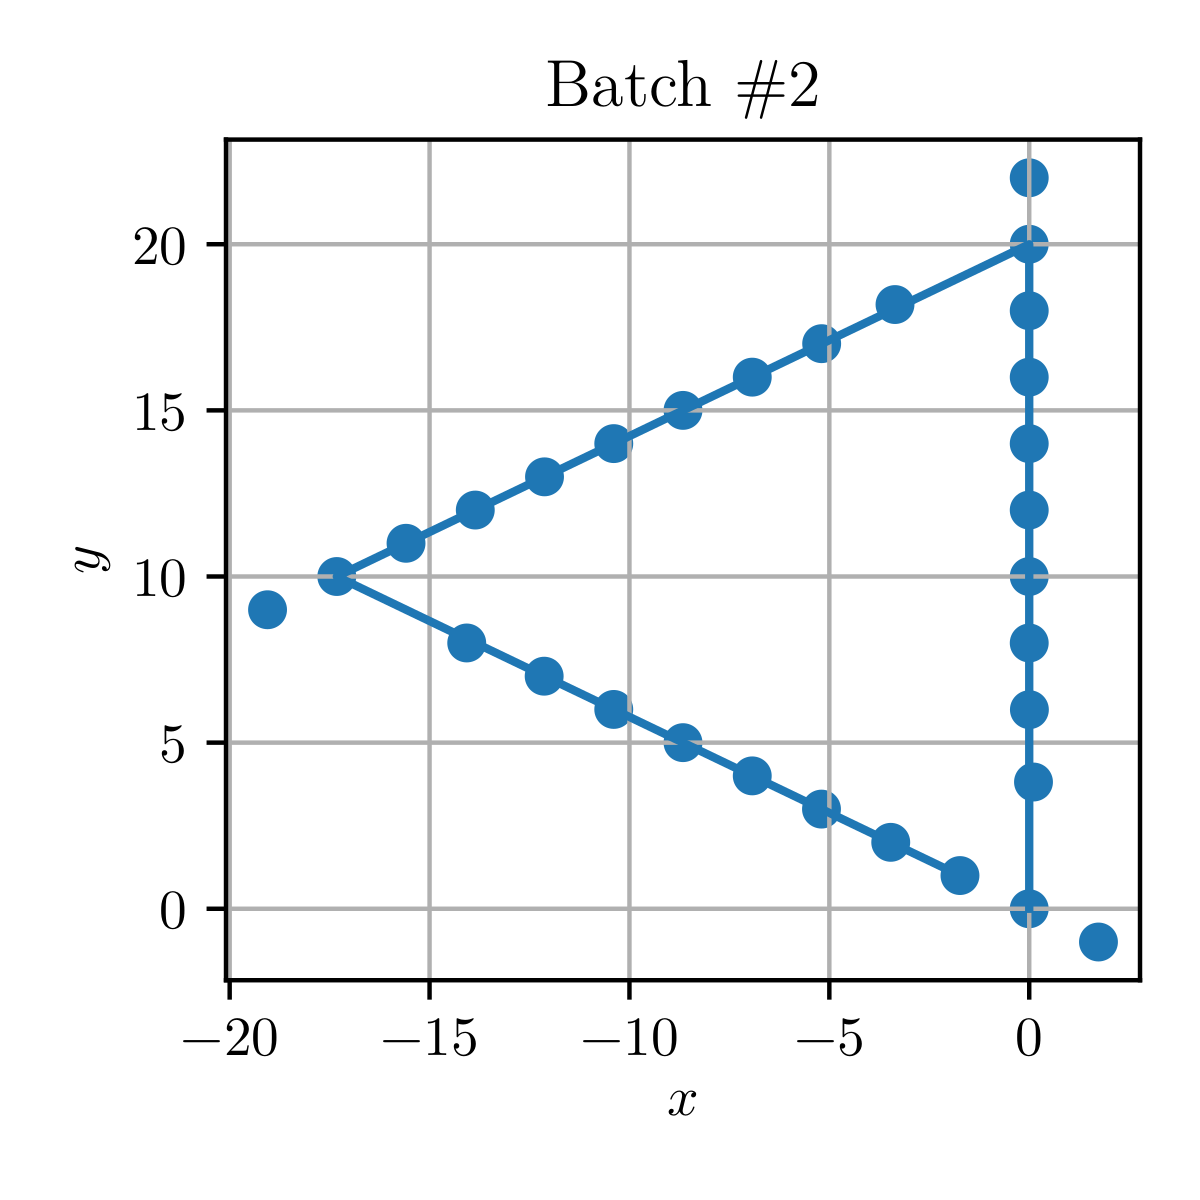
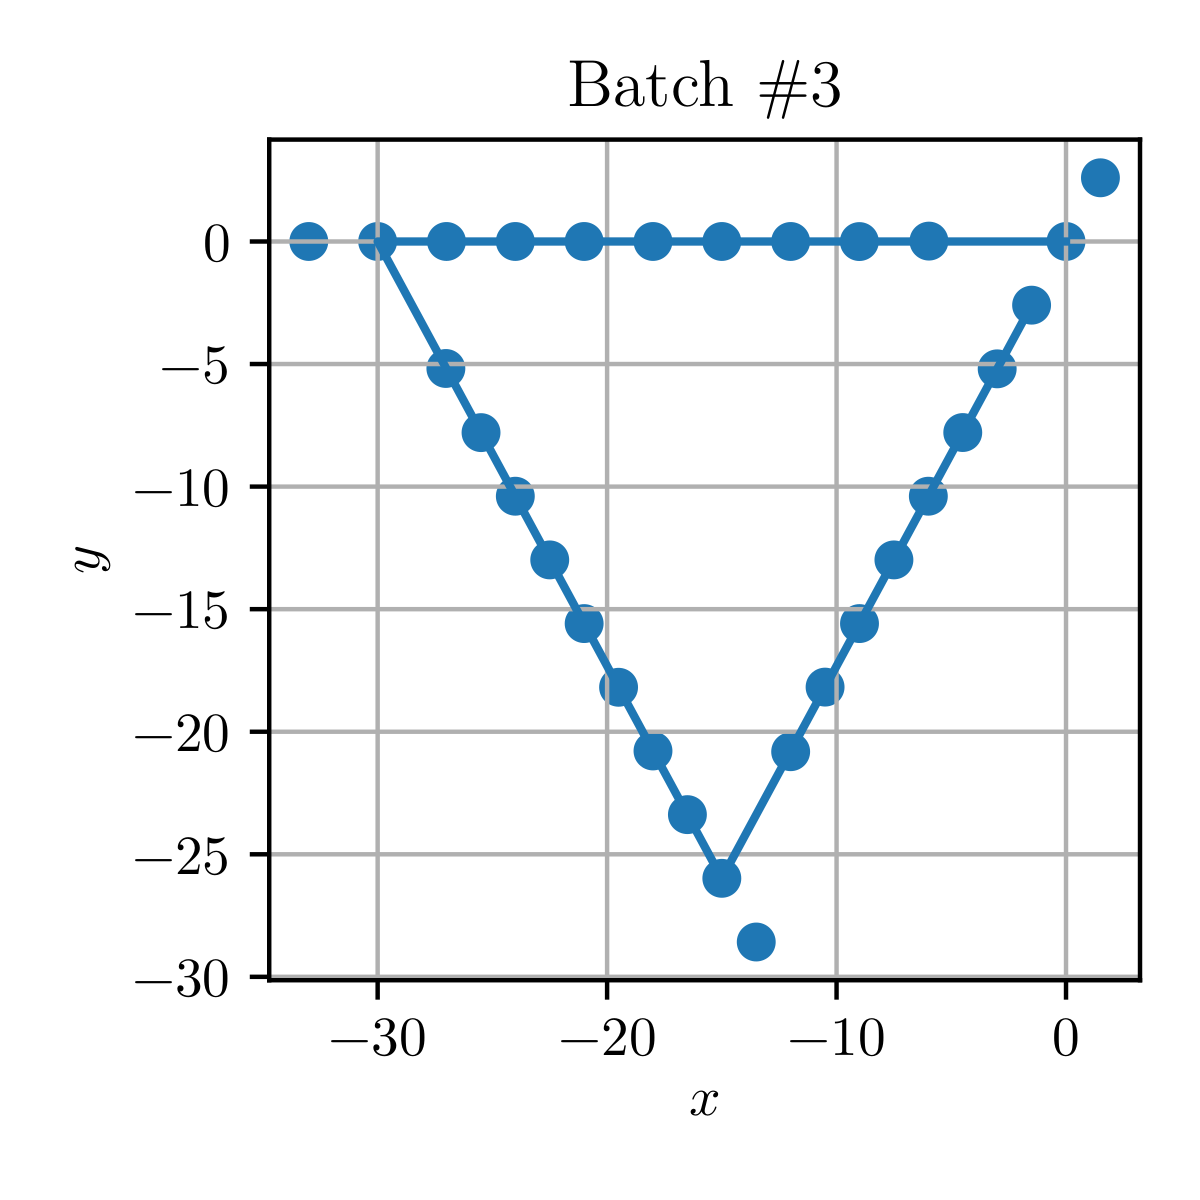
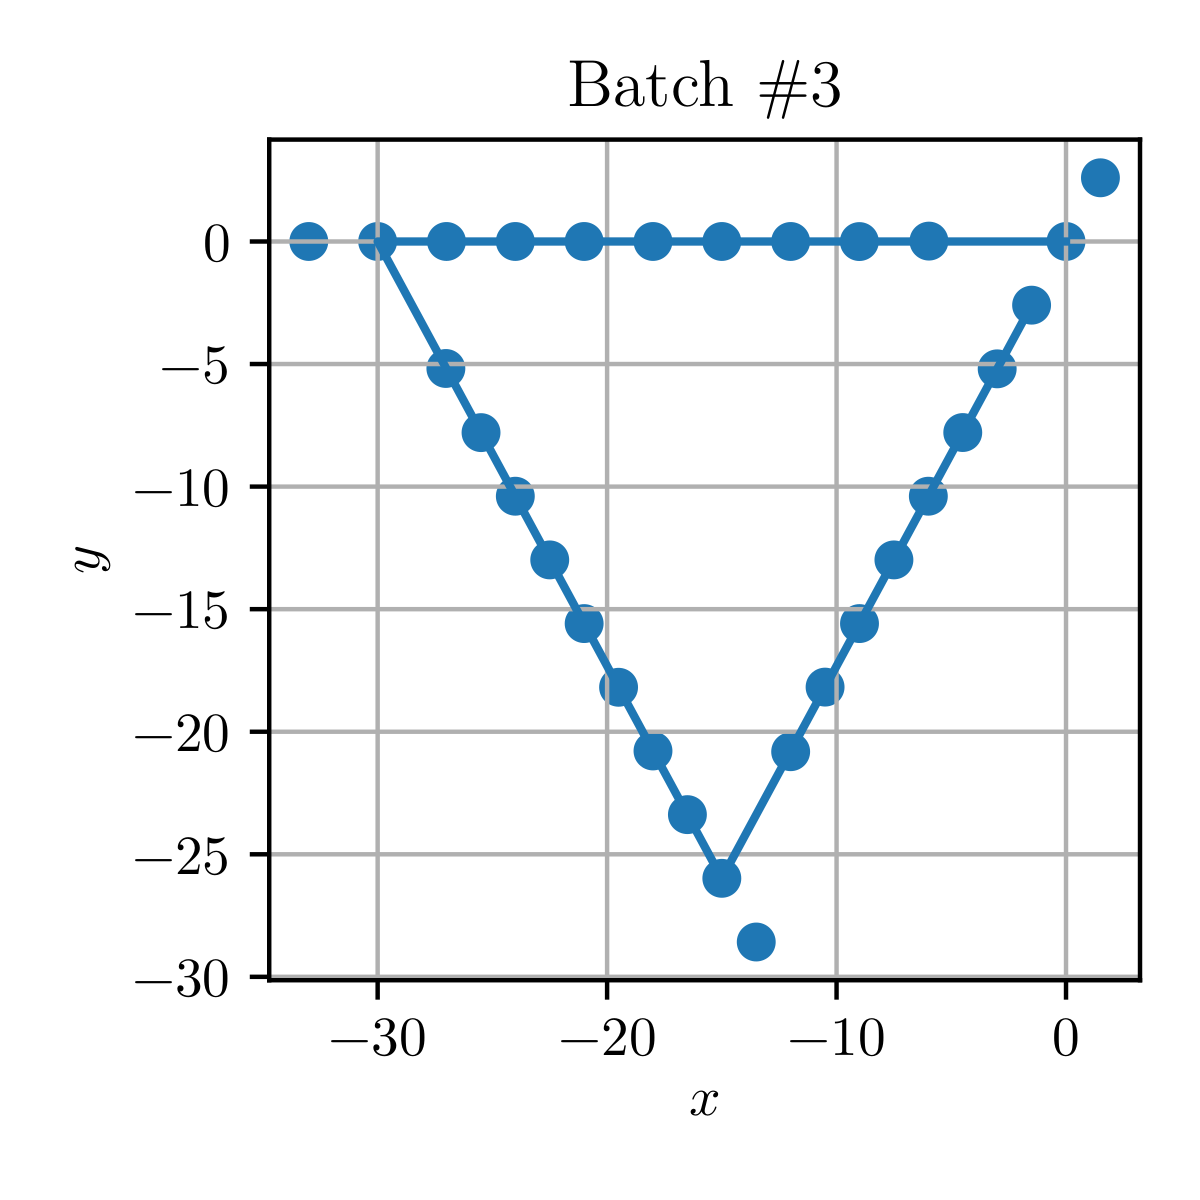
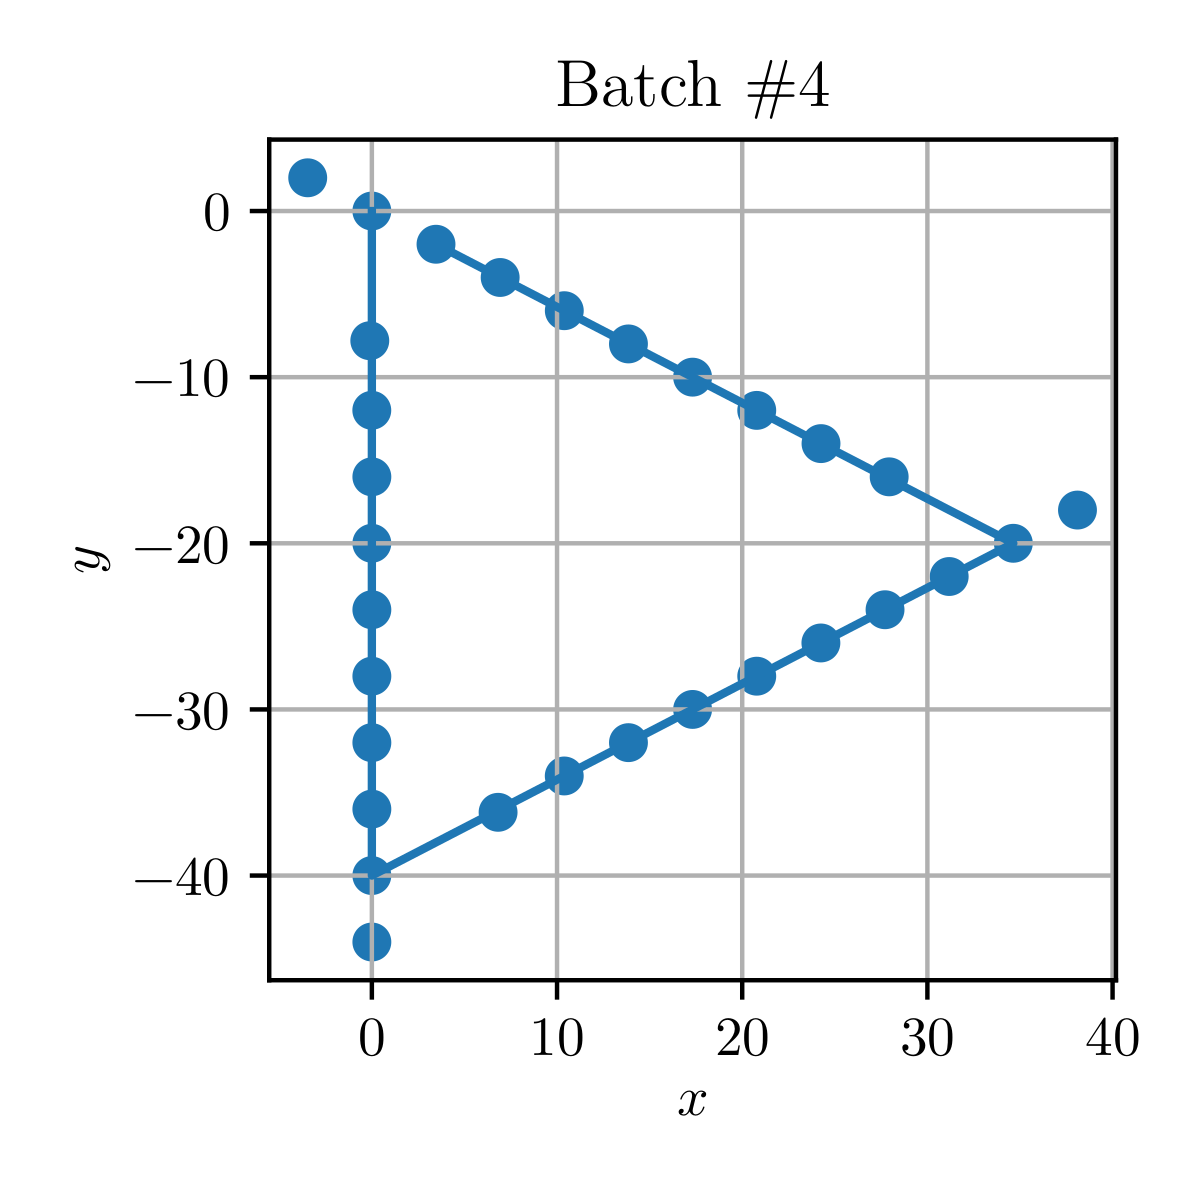
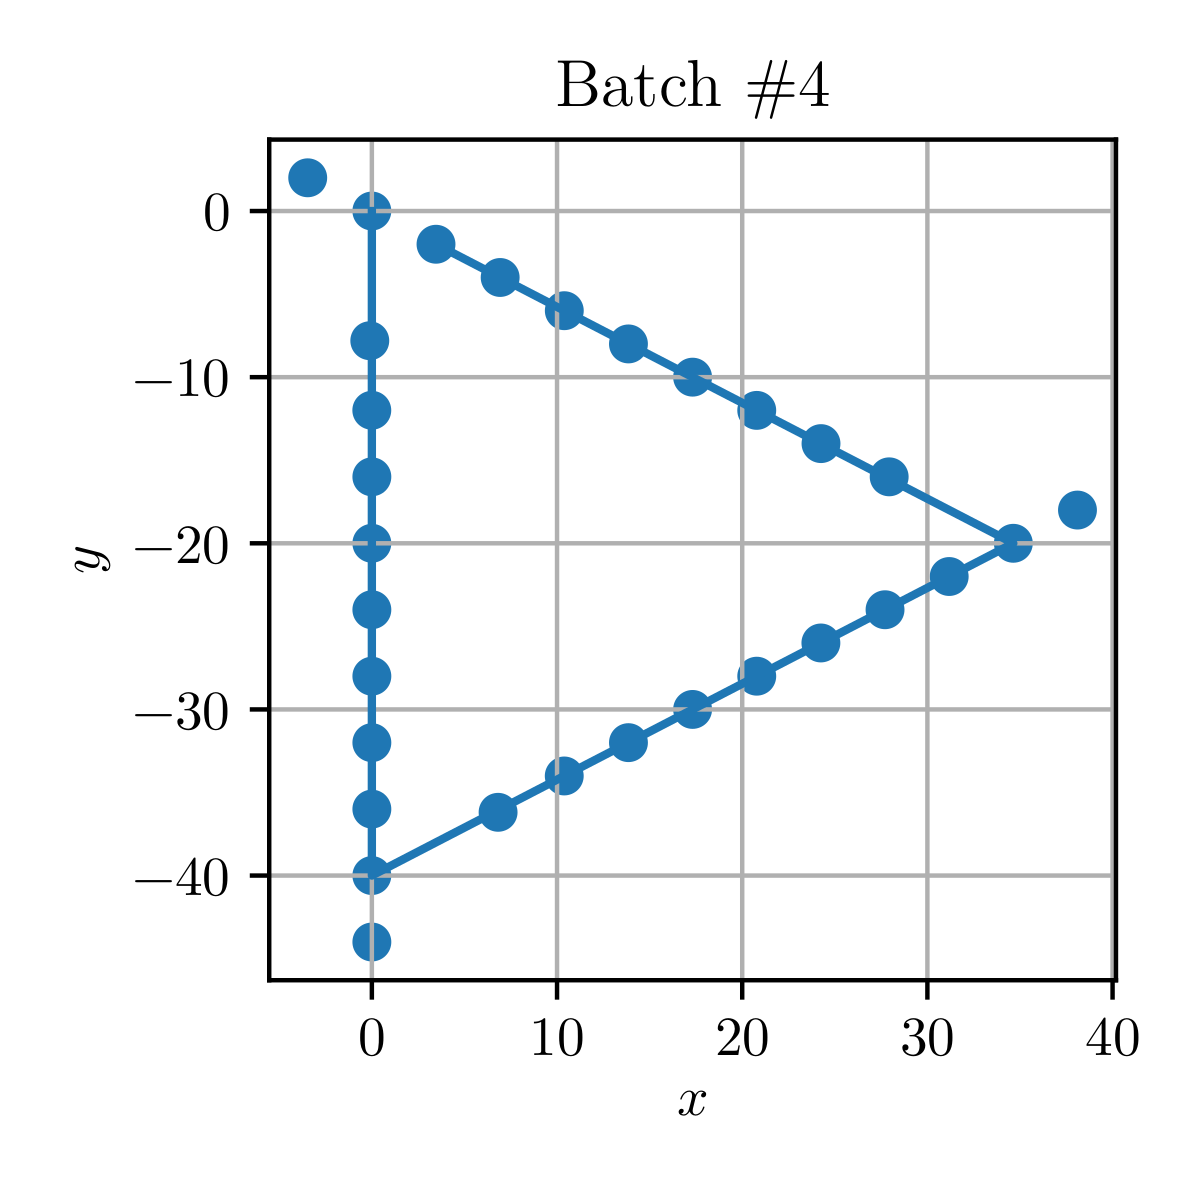

In [16]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, -30:], X[:, :, -30:], 0, 'pred_b1'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 1, 'pred_b2'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 2, 'pred_b3'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 3, 'pred_b4'),
], n_columns=4)

[Download loss_b1.png],[Download loss_b2.png],[Download loss_b3.png],[Download loss_b4.png]

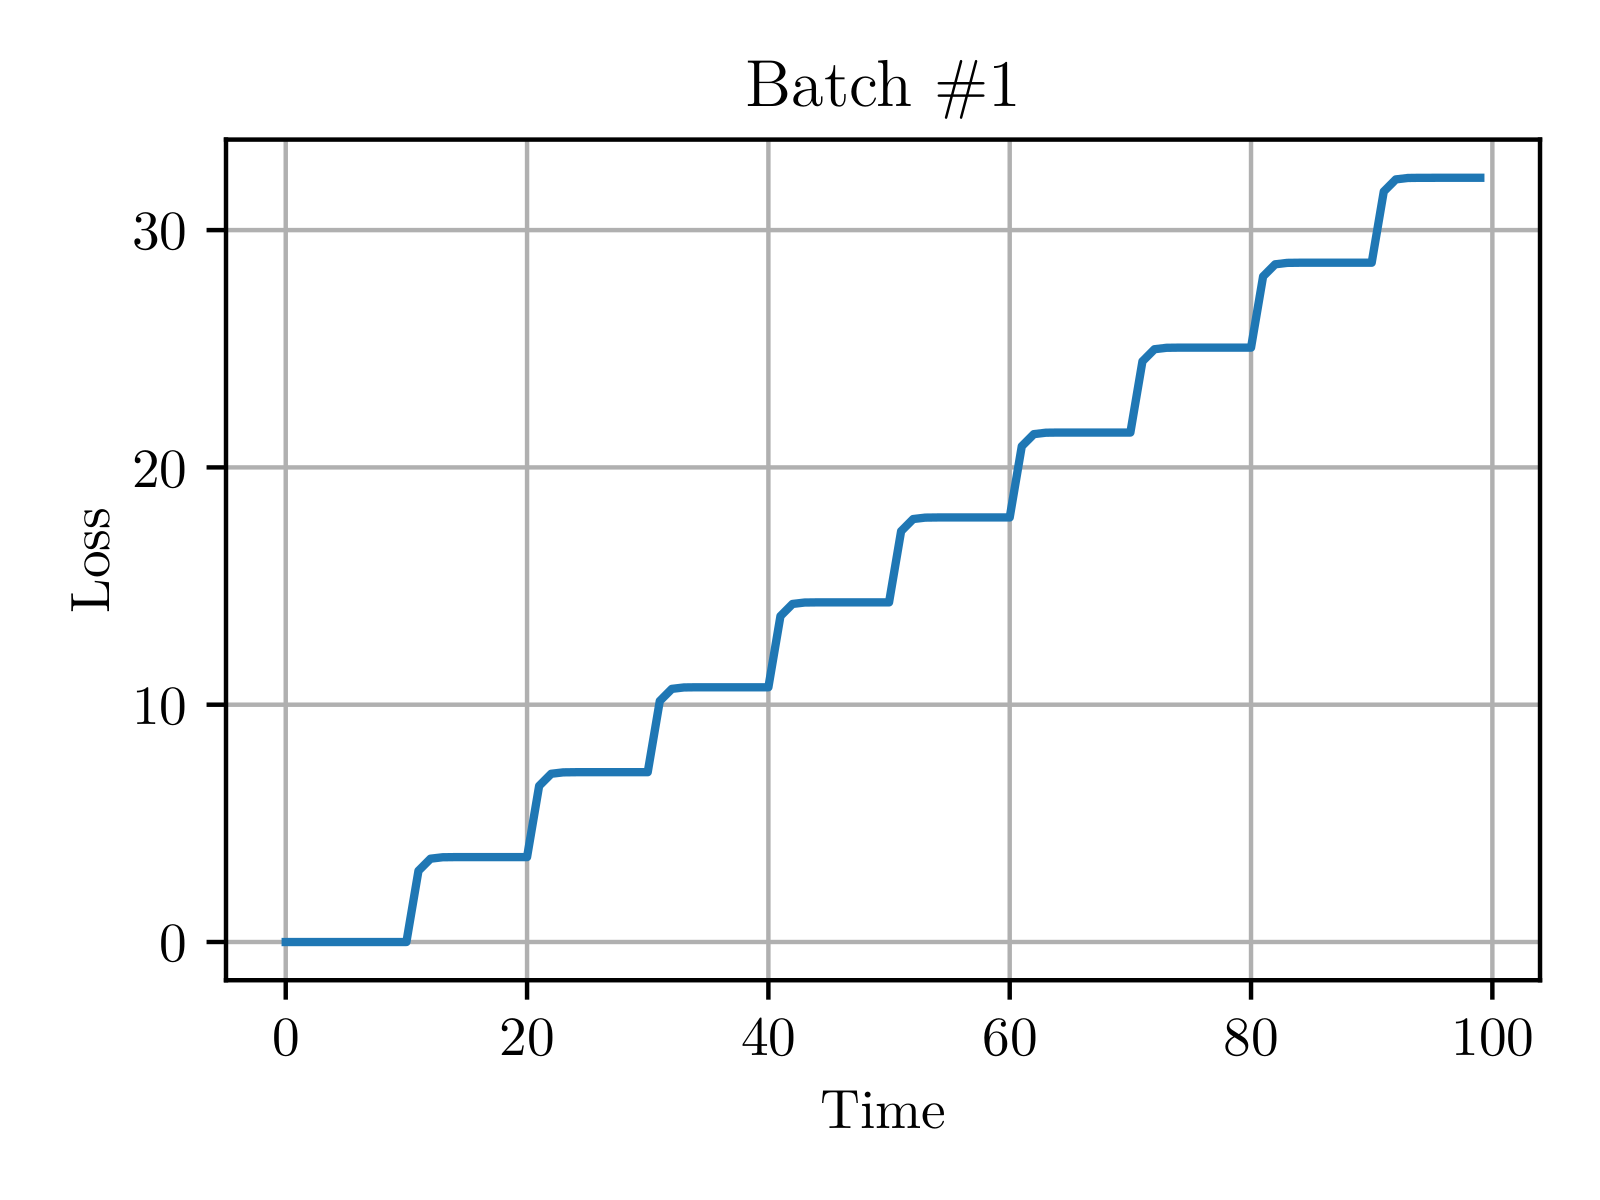
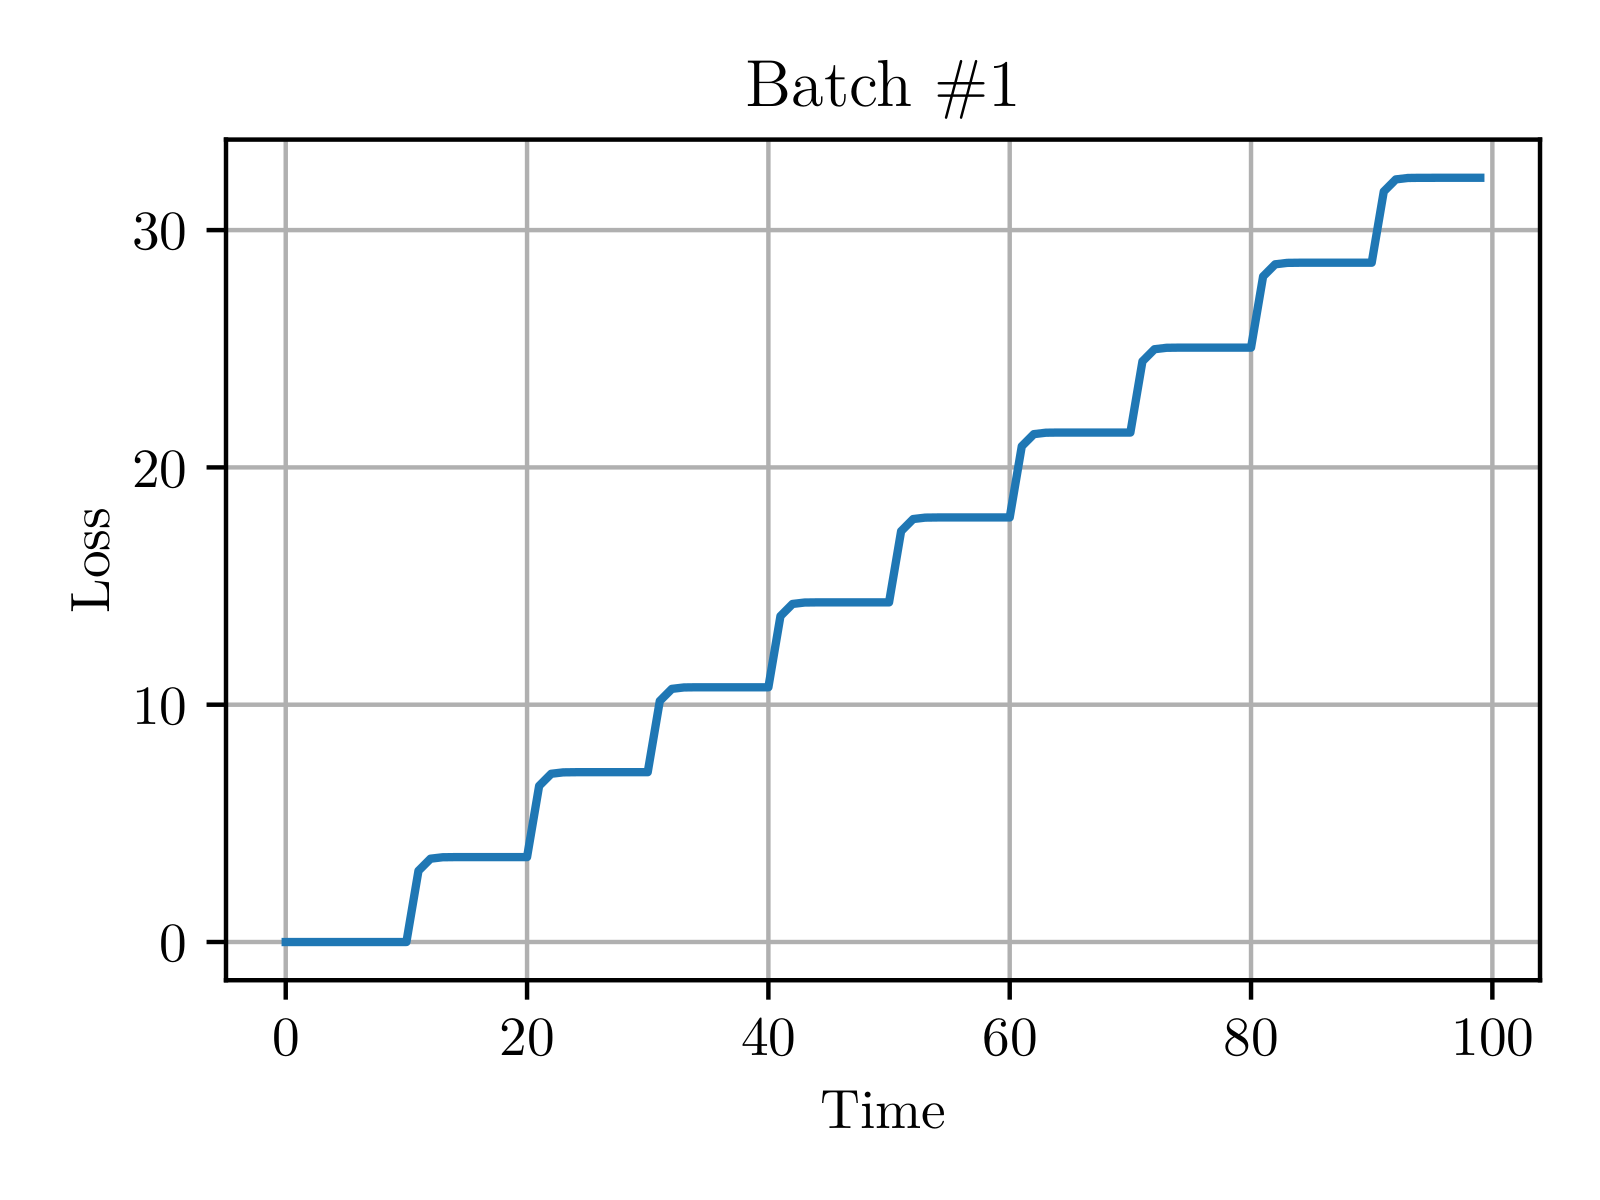
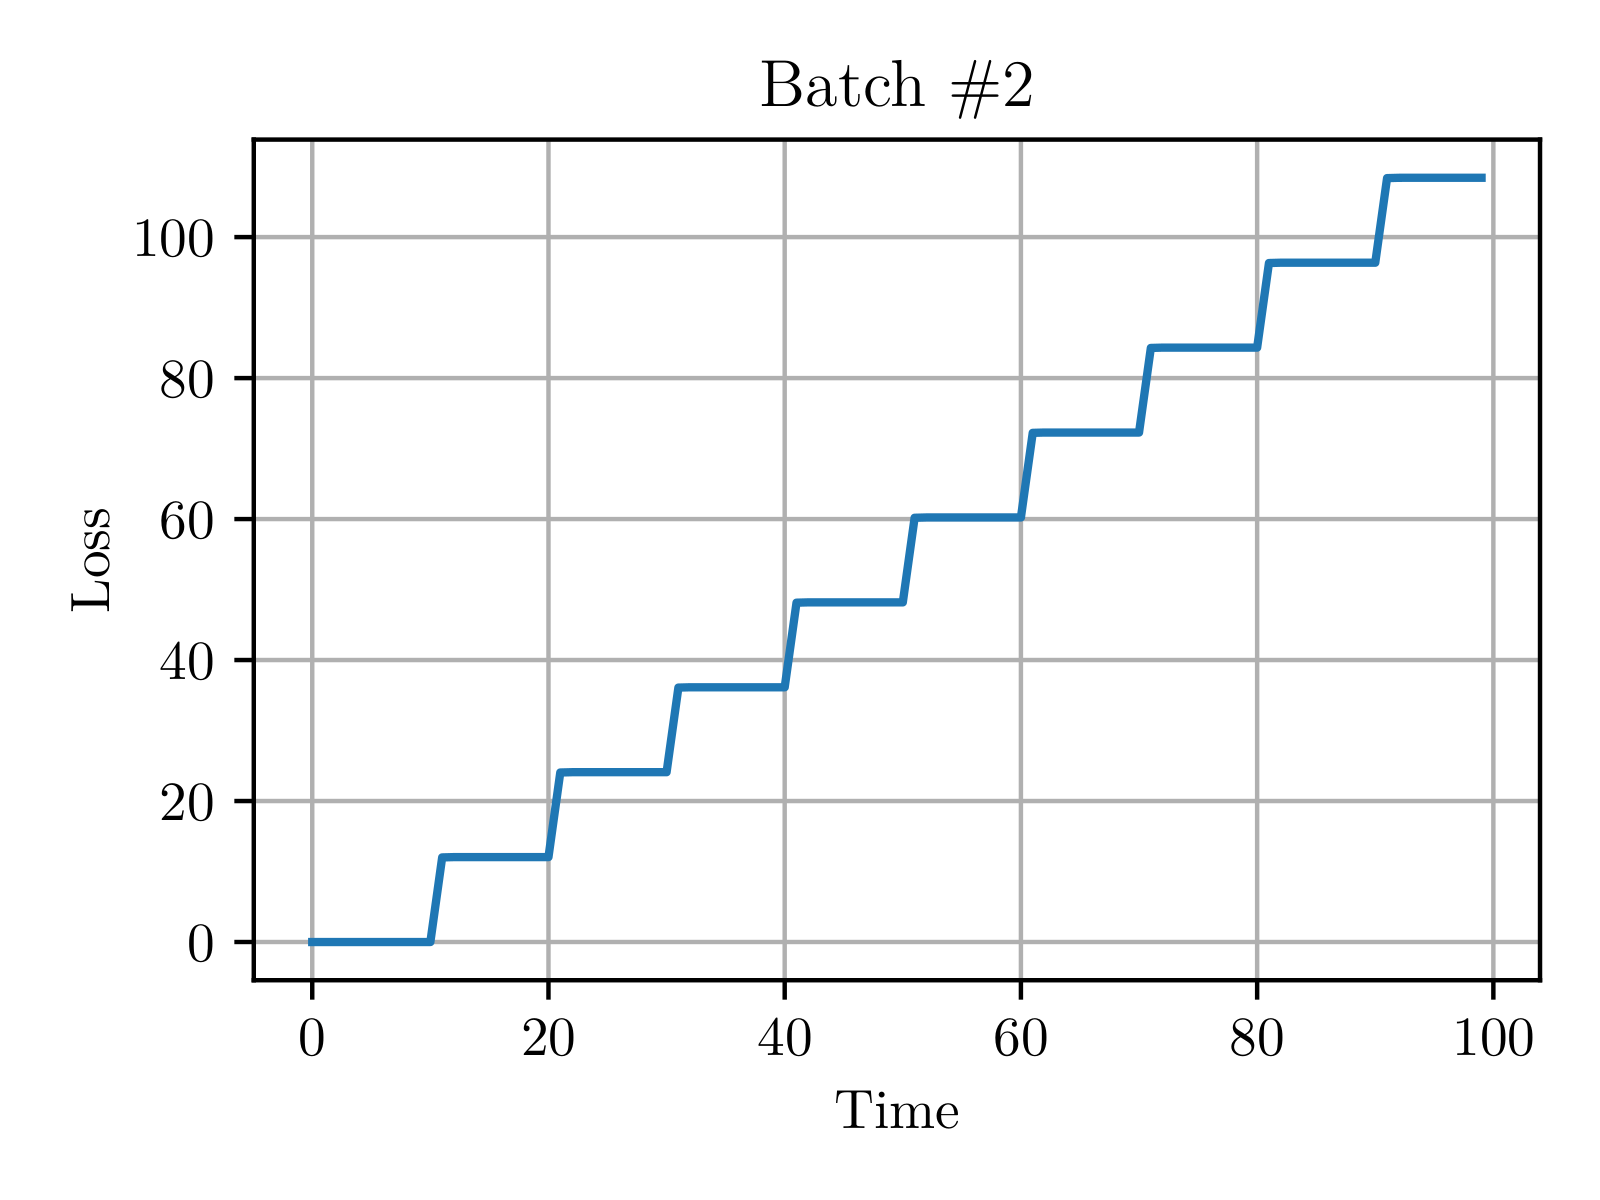
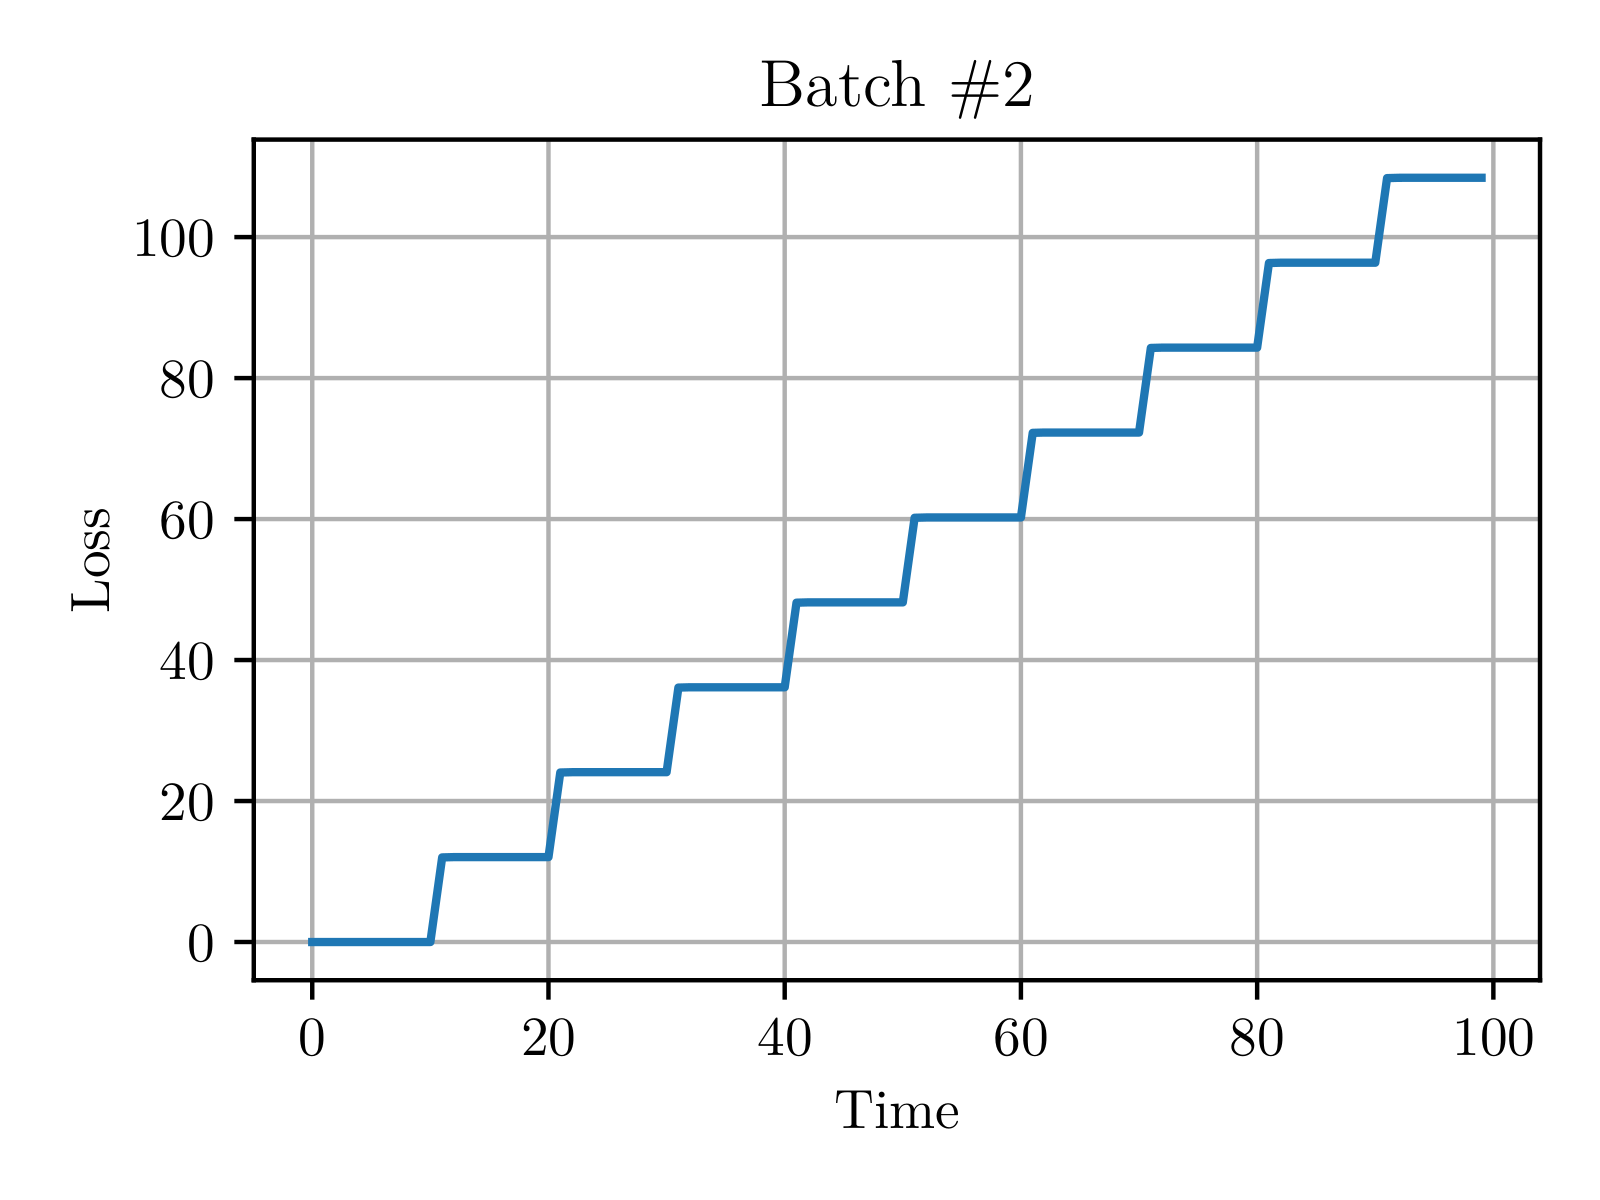
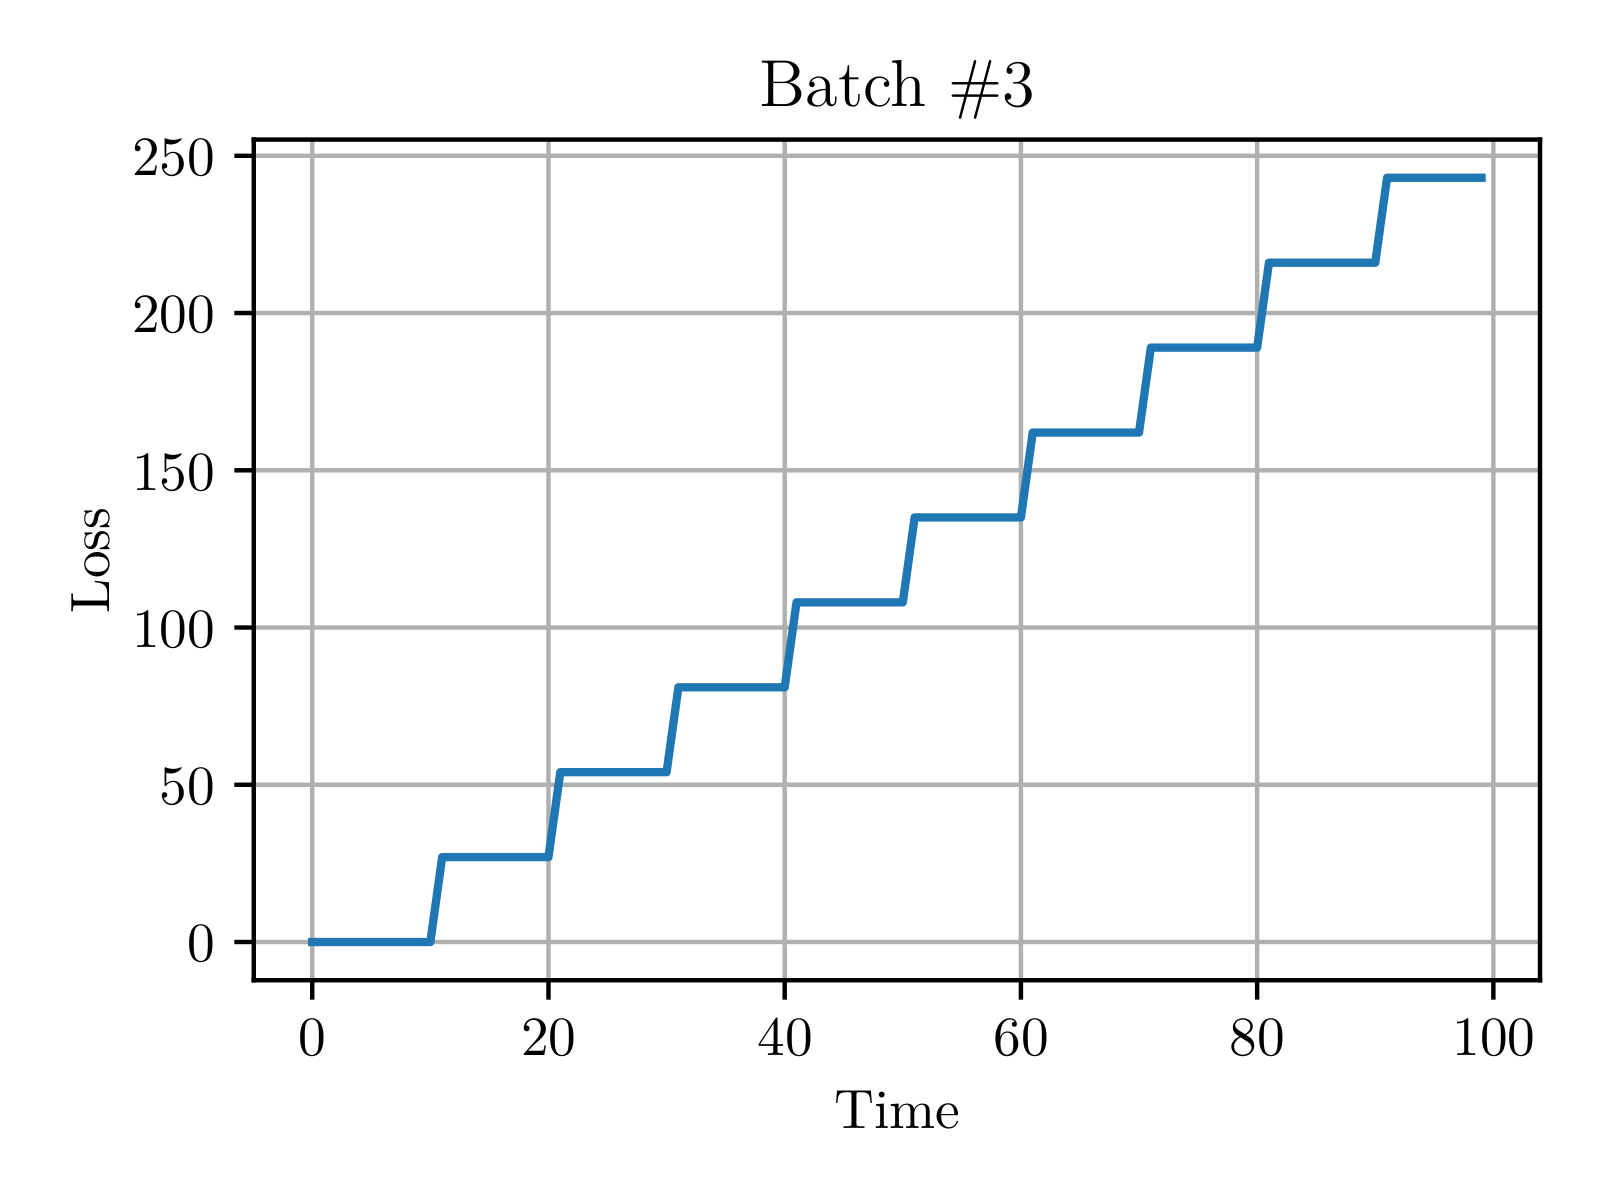
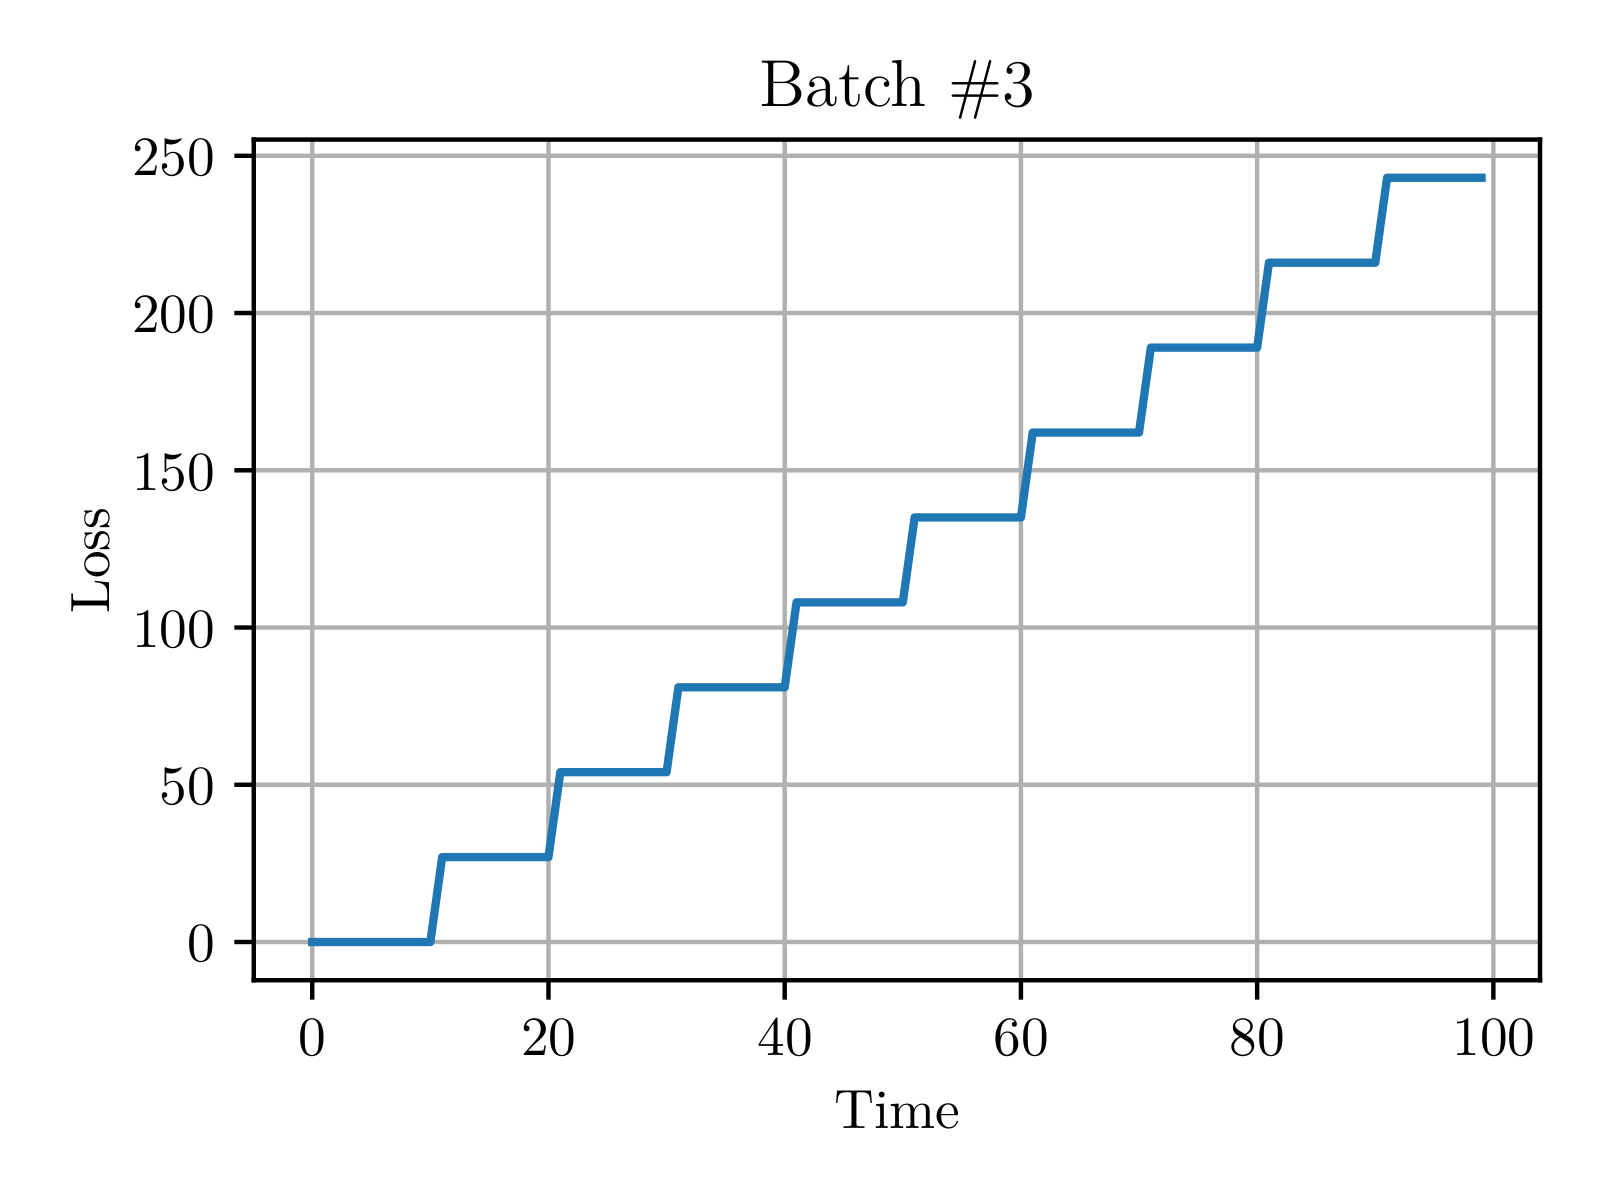
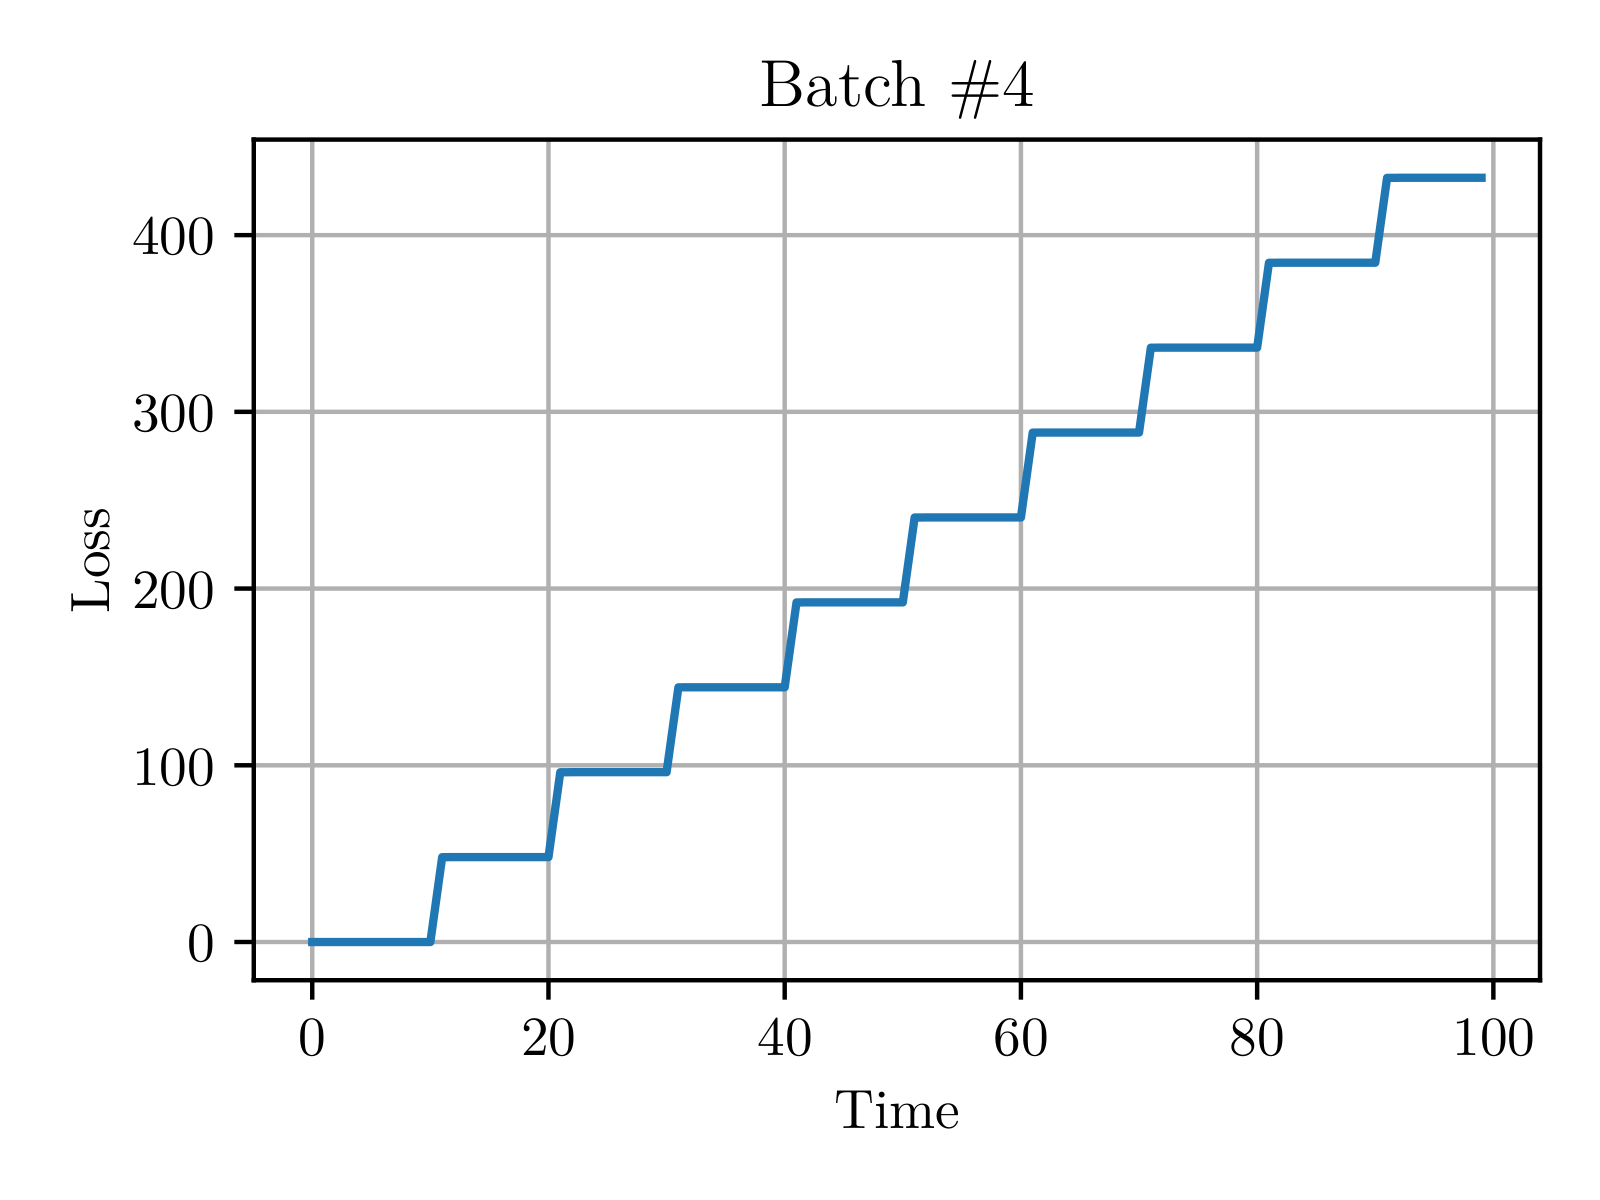
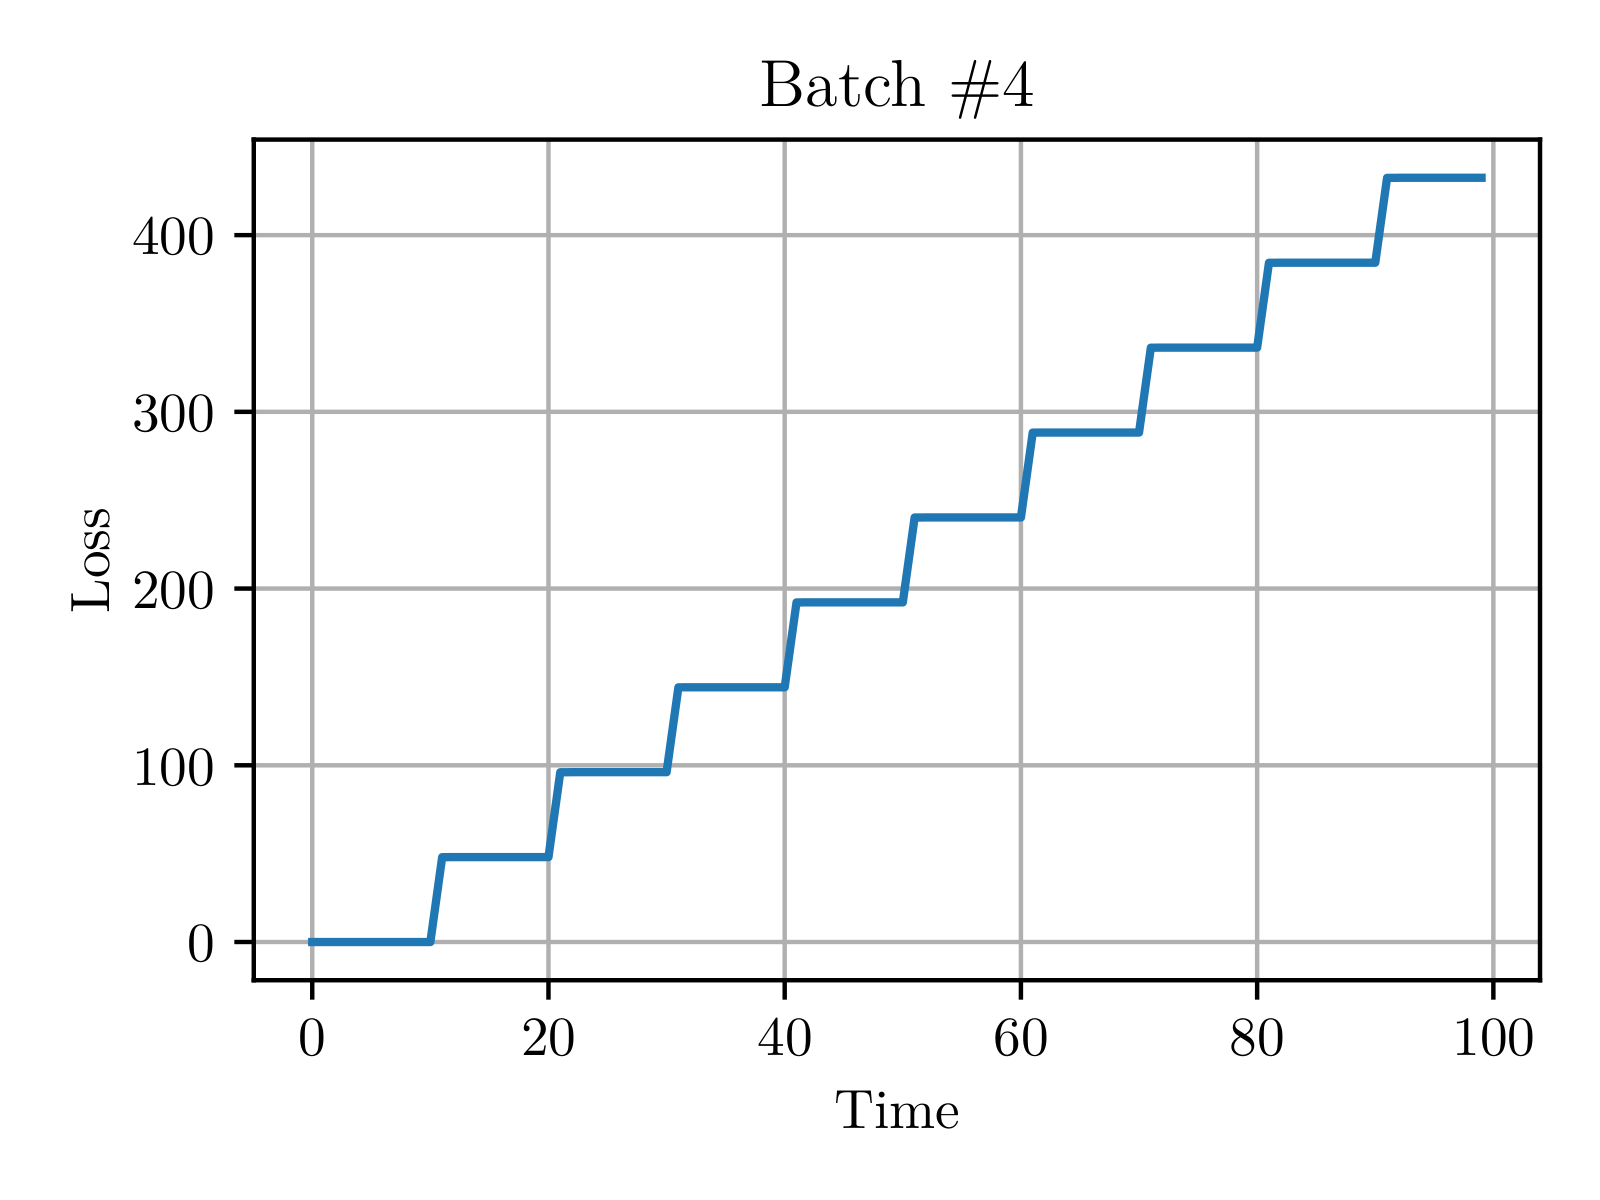

In [17]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses[:, :100], 0, 'loss_b1'),
    plot(losses[:, :100], 1, 'loss_b2'),
    plot(losses[:, :100], 2, 'loss_b3'),
    plot(losses[:, :100], 3, 'loss_b4'),
], n_columns=4)